# Structural DNA helical parameters from MD trajectory tutorial using BioExcel Building Blocks (biobb)
Based on the [**NAFlex**](https://mmb.irbbarcelona.org/NAFlex) server and in particular in its [**Nucleic Acids Analysis**](https://mmb.irbbarcelona.org/NAFlex/help.php?id=tutorialAnalysisNA) section. 

***
This tutorial aims to illustrate the process of **extracting structural and dynamical properties** from a **DNA MD trajectory helical parameters**, step by step, using the **BioExcel Building Blocks library (biobb)**. The particular example used is the **Drew Dickerson Dodecamer** sequence -CGCGAATTCGCG- (PDB code [1BNA](https://www.rcsb.org/structure/1BNA)). The trajectory used is a  500ns-long MD simulation taken from the [BigNASim](https://mmb.irbbarcelona.org/BIGNASim/) database ([NAFlex_DDD_II](https://mmb.irbbarcelona.org/BIGNASim/getStruc.php?idCode=NAFlex_DDD_II) entry).  
***

## Settings

### Biobb modules used

 - [biobb_dna](https://github.com/bioexcel/biobb_dna): Tools to analyse DNA structures and MD trajectories.
 
### Auxiliar libraries used

 - [nb_conda_kernels](https://github.com/Anaconda-Platform/nb_conda_kernels): Enables a Jupyter Notebook or JupyterLab application in one conda environment to access kernels for Python, R, and other languages found in other environments.
 - [ipywidgets](https://github.com/jupyter-widgets/ipywidgets): Interactive HTML widgets for Jupyter notebooks and the IPython kernel.
 - [matplotlib](https://matplotlib.org/): Comprehensive library for creating static, animated, and interactive visualizations in Python. 


### Conda Installation and Launch

```console
git clone https://github.com/bioexcel/biobb_wf_dna_helparms.git
cd biobb_wf_dna_helparms
conda env create -f conda_env/environment.yml
conda activate biobb_dna_helparms_tutorial
jupyter-nbextension enable --py --user widgetsnbextension
jupyter-notebook biobb_wf_md_setup/notebooks/biobb_dna_helparms_tutorial.ipynb
  ``` 

***
## Pipeline steps
 1. [Input Parameters](#input)
 2. [Running Curves+ and Canal](#curves)
 3. [Average Helical Parameters](#averages)
     1. [Base Pair Step (Inter Base Pair) Parameters](#avg_bps)
     2. [Base Pair (Intra Base Pair) Parameters](#avg_bp)
     3. [Axis Parameters](#avg_axis)
     4. [Grooves](#avg_grooves)
     5. [Backbone Torsions](#avg_backbone)
 8. [Time Series Helical Parameters](#timeseries)
 8. [Stiffness](#stiffness)
 9. [Bimodality](#bimodality)
 10. [Correlations](#correlations)
     1. [Sequence Correlations: Intra-base pairs](#intrasequencecorrelation)
     2. [Sequence Correlations: Inter-base pair steps](#intersequencecorrelation)
     3. [Helical Parameter Correlations: Intra-base pairs](#intrahelparcorrelation)
     4. [Helical Parameter Correlations: Inter-base pair steps](#interhelparcorrelation)
     5. [Neighboring steps Correlations: Intra-base pairs](#intrabasepaircorrelation)
     6. [Neighboring steps Correlations: Inter-base pair steps](#interbasepaircorrelation)
 11. [Questions & Comments](#questions)
 
***
<img src="https://bioexcel.eu/wp-content/uploads/2019/04/Bioexcell_logo_1080px_transp.png" alt="Bioexcel2 logo"
	title="Bioexcel2 logo" width="400" />
***


In [5]:
# Auxiliar libraries

import os
import shutil
import glob
from pathlib import Path, PurePath
import zipfile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image
import ipywidgets


<a id="input"></a>
## Input parameters
**Input parameters** needed:
 - **seq**: Sequence of the DNA structure (e.g. CGCGAATTCGCG)
 - **seq_comp**: Complementary sequence of the given DNA structure (e.g. CGCGAATTCGCG)
 
 - **traj**: Trajectory for a 500ns Drew Dickerson Dodecamer MD simulation (taken from [BigNASim](https://mmb.irbbarcelona.org/BIGNASim/)) 
 - **top**: Associated topology for the MD trajectory 

In [6]:
# Input parameters
seq = "CGCGAATTCGCG"
seq_comp = "CGCGAATTCGCG"

traj = "TRAJ/structure.stripped.nc"
top = "TRAJ/structure.stripped.top"

# Auxiliar lists
grooves = ('majd','majw','mind','minw')
axis_base_pairs = ('inclin','tip','xdisp','ydisp')
base_pair = ('shear','stretch','stagger','buckle','propel','opening')
base_pair_step = ('rise','roll','twist','shift','slide','tilt')
backbone_torsions = ('alphaC', 'alphaW', 'betaC', 'betaW', 'gammaC', 'gammaW', 'deltaC', 'deltaW', \
'epsilC', 'epsilW', 'zetaC', 'zetaW', 'chiC', 'chiW', 'phaseC', 'phaseW')

<a id="curves"></a>
## Running Curves+ and Canal

***
**Curves+** program and its associated **Canal** tool allow us to extract **helical parameters** from a **DNA MD simulation**.

**Curves+** is a **nucleic acid conformational analysis program** which provides both **helical** and **backbone parameters**, including a curvilinear axis and parameters relating the position of the bases to this axis. It additionally provides a full analysis of **groove widths** and **depths**. **Curves+** can also be used to analyse **molecular dynamics trajectories**. With the help of the accompanying program **Canal**, it is possible to produce a variety of graphical output including parameter variations along a given structure and **time series** or **histograms** of parameter variations during dynamics.

**Conformational analysis of nucleic acids revisited: Curves+**<br>
*R. Lavery, M. Moakher, J. H. Maddocks, D. Petkeviciute, K. Zakrzewska*<br>
***Nucleic Acids Research, Volume 37, Issue 17, 1 September 2009, Pages 5917–5929***<br>
https://doi.org/10.1093/nar/gkp608


**CURVES+ web server for analyzing and visualizing the helical, backbone and groove parameters of nucleic acid structure.**<br>
*R. Lavery, M. Moakher, J.H. Maddocks, D. Petkeviciute, K. Zakrzewska.*<br>
***Nucleic Acids Res 2009, 37:5917-5929***<br>
https://bisi.ibcp.fr/tools/curves_plus/

***
**Building Blocks** used:
- [curves](https://biobb-dna.readthedocs.io/en/latest/curvesplus.html#module-curvesplus.biobb_curves) from **biobb_dna.curvesplus.biobb_curves**
- [canal](https://biobb-dna.readthedocs.io/en/latest/curvesplus.html#module-curvesplus.biobb_canal) from **biobb_dna.curvesplus.biobb_canal**
***
The extraction of **helical parameters** is then done in **two steps**:

- [Step 1: Curves+](#curves1): Reading input **MD trajectory** and analysing **helical parameters**.
- [Step 2: Canal](#canal2): Taking **Curves+** output and generating **time series** and/or **histograms** of parameter variations during dynamics.

***

<a id="curves1"></a>
### Step 1: Curves+

**Curves+** program needs a **trajectory** and its associated **topology**, and a couple of **ranges**, informing about the numeration of the two **DNA strands**: s1range and s2range.

In [ ]:
from biobb_dna.curvesplus.biobb_curves import curves

curves_out_lis = "curves.out.lis"
curves_out_cda = "curves.out.cda"

prop = {
    's1range' : '1:12',
    's2range' : '24:13'
}

curves(
    input_struc_path=traj,
    input_top_path=top,
    output_lis_path=curves_out_lis,
    output_cda_path=curves_out_cda,
    properties=prop
)

<a id="canal2"></a>
### Step 2: Canal

**Canal** program needs the output of the previous **Curves+** execution, and is able to produce **time series** (series property) and **histograms** (histo property) for the **parameter variations** during dynamics.

In [ ]:
from biobb_dna.curvesplus.biobb_canal import canal

canal_out = "canal.out.zip"

prop = {
    'series' : True,
    'histo' : True
}

canal(
    input_cda_file=curves_out_cda,
    input_lis_file=curves_out_lis,
    output_zip_path=canal_out,
    properties=prop
)

### Extracting Canal results in a temporary folder

In [9]:
canal_dir = "canal_out"

if Path(canal_dir).exists(): shutil.rmtree(canal_dir) 
os.mkdir(canal_dir)

with zipfile.ZipFile(canal_out, 'r') as zip_ref:
    zip_ref.extractall(canal_dir)

<a id="averages"></a>

## Extracting Average Helical Parameters

**Average helical parameter** values can be computed from the output of **Curves+/Canal** execution. 

The **helical parameters** can be divided in 5 main blocks:

- [Helical Base Pair Step (Inter-Base Pair) Helical Parameters](#avg_bps)
- [Helical Base Pair (Intra-Base Pair) Helical Parameters](#avg_bp)
- [Axis Base Pair](#avg_axis)
- [Grooves](#avg_grooves)
- [Backbone Torsions](#avg_backbone)


<a id="avg_bps"></a>

### Helical Base Pair Step (Inter Base Pair) Parameters

**Translational (Shift, Slide, Rise)** and **rotational (Tilt, Roll, Twist)** parameters related to a **dinucleotide Inter-Base Pair** (Base Pair Step).

- **Shift**: Translation around the X-axis.
- **Slide**: Translation around the Y-axis.
- **Rise**: Translation around the Z-axis.
- **Tilt**: Rotation around the X-axis.
- **Roll**: Rotation around the Y-axis.
- **Twist**: Rotation around the Z-axis.

***
<img src="https://mmb.irbbarcelona.org/NAFlex/images/helicalParamsBPS.png" alt="Helical Base Pair Step Parameters"
	title="Helical Base Pair Step Parameters" width="400" />
***
**Building Block** used:
- [helparaverages](https://biobb-dna.readthedocs.io/en/latest/dna.html#module-dna.dna_averages) from **biobb_dna.dna.dna_averages** 
***

#### Extracting a particular Helical Parameter: Rise

In [ ]:
from biobb_dna.dna.dna_averages import helparaverages

helpar = 'rise'

input_file_path = "canal_out/canal_output" + "_" + helpar + ".ser"
output_averages_csv_path= helpar+'.averages.csv'
output_averages_jpg_path= helpar+'.averages.jpg'

prop = {
    'helpar_name': helpar,
    'sequence': seq
}

helparaverages(
    input_ser_path=input_file_path,
    output_csv_path=output_averages_csv_path,
    output_jpg_path=output_averages_jpg_path,
    properties=prop)

#### Showing the calculated average values for Rise helical parameter

In [11]:
output_averages_csv_path= helpar+'.averages.csv'
df = pd.read_csv(output_averages_csv_path)
df

Base Pair Step      mean       std
0             GC  3.470550  0.377972
1             CG  2.978038  0.454661
2             GA  3.377096  0.408705
3             AA  3.363942  0.378155
4             AT  3.444138  0.355242
5             TT  3.374110  0.376290
6             TC  3.370114  0.411934
7             CG  2.982740  0.454215
8             GC  3.464096  0.390428

#### Plotting the average values for Rise helical parameter 

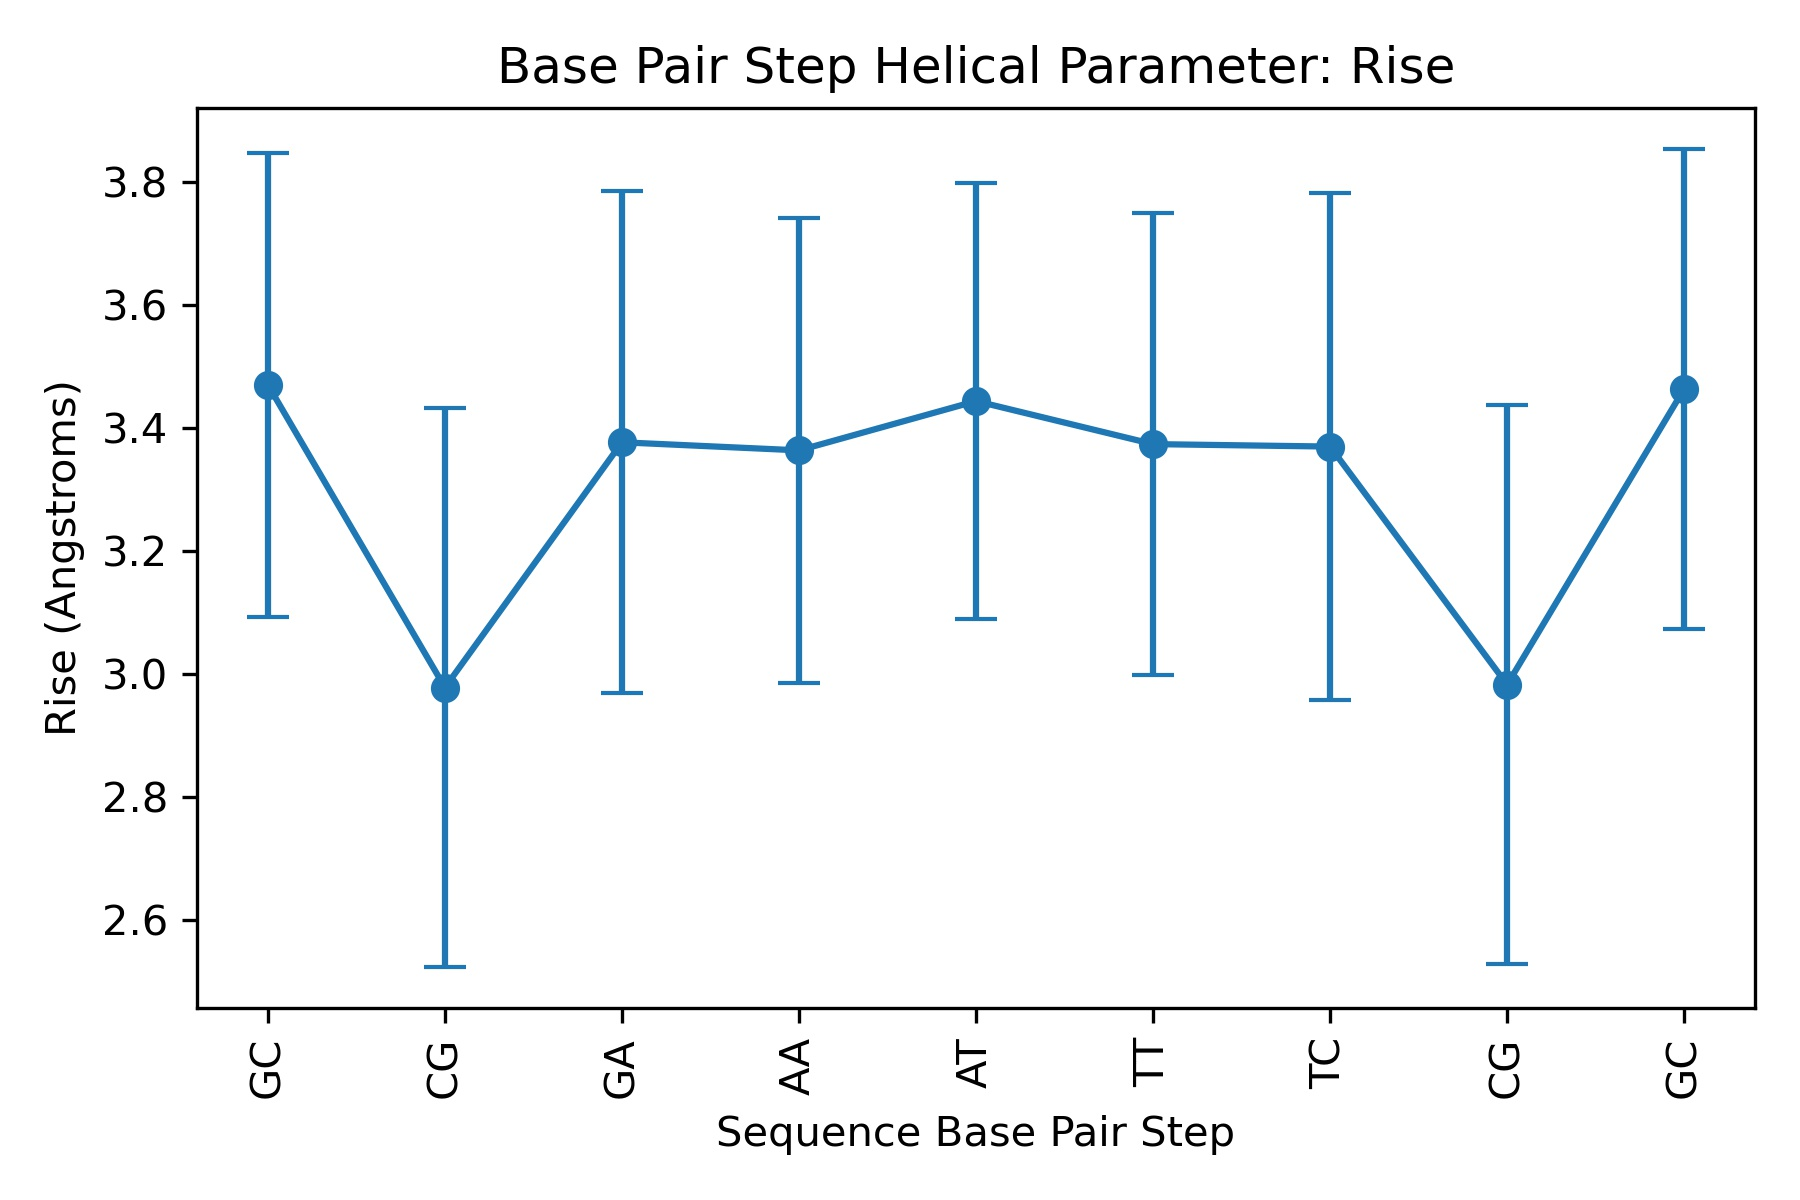

In [12]:
Image(filename=output_averages_jpg_path,width = 600)

#### Computing average values from all base-pair step parameters

In [ ]:
from biobb_dna.dna.dna_averages import helparaverages

for helpar in base_pair_step:

    input_file_path = "canal_out/canal_output" + "_" + helpar + ".ser"
    output_averages_csv_path= helpar+'.averages.csv'
    output_averages_jpg_path= helpar+'.averages.jpg'

    prop = {
        'helpar_name': helpar,
        'sequence': seq
    }

    helparaverages(
        input_ser_path=input_file_path,
        output_csv_path=output_averages_csv_path,
        output_jpg_path=output_averages_jpg_path,
        properties=prop)

#### Showing the calculated average values for all base-pair step helical parameters

In [ ]:
for helpar in base_pair_step:
    output_averages_csv_path= helpar+'.averages.csv'
    df = pd.read_csv(output_averages_csv_path)
    print("Helical Parameter: " + helpar)
    print(df)
    print("---------\n")

#### Plotting the average values for all base-pair step helical parameters 

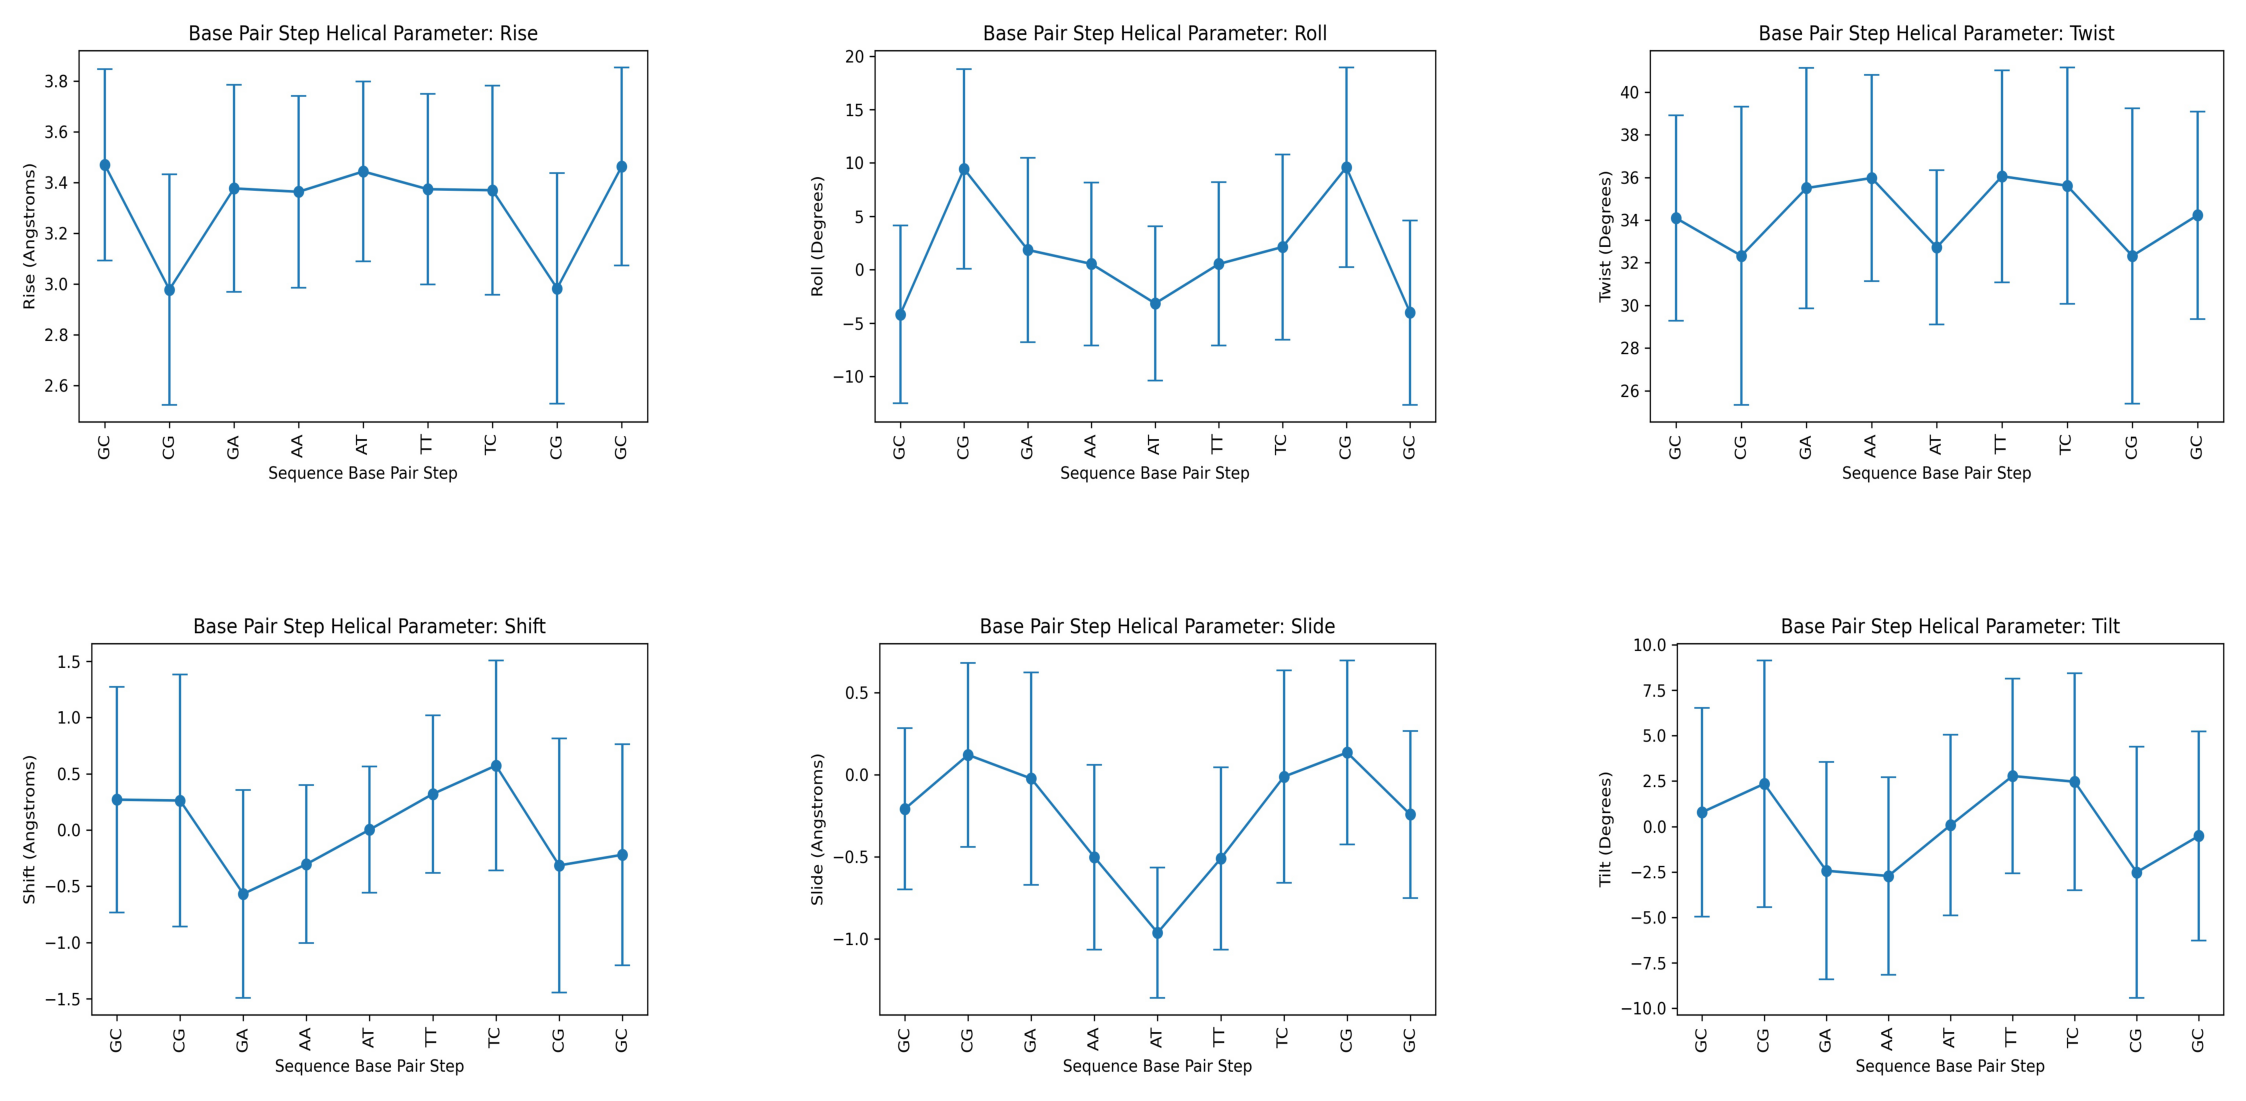

In [15]:
images = []
for helpar in base_pair_step:
    images.append(helpar + '.averages.jpg')

f, axarr = plt.subplots(2, 3, figsize=(40, 20))

for i, image in enumerate(images):
    y = i%3
    x = int(i/3)

    img = mpimg.imread(image)

    axarr[x,y].imshow(img, aspect='auto')
    axarr[x,y].axis('off')

plt.show()


<a id="avg_bp"></a>
### Helical Base Pair (Intra Base Pair) Parameters

**Translational (Shear, Stretch, Stagger)** and **rotational (Buckle, Propeller, Opening)** parameters related to a **dinucleotide Intra-Base Pair**.

- **Shear**: Translation around the X-axis.
- **Stretch**: Translation around the Y-axis.
- **Stagger**: Translation around the Z-axis.
- **Buckle**: Rotation around the X-axis.
- **Propeller**: Rotation around the Y-axis.
- **Opening**: Rotation around the Z-axis.

***
<img src="https://mmb.irbbarcelona.org/NAFlex/images/helicalParamsBP.png" alt="Helical Base Pair Parameters"
	title="Helical Base Pair Parameters" width="400" />
***
**Building Block** used:
- [helparaverages](https://biobb-dna.readthedocs.io/en/latest/dna.html#module-dna.dna_averages) from **biobb_dna.dna.dna_averages** 
***

#### Computing average values from all base-pair parameters

In [ ]:
from biobb_dna.dna.dna_averages import helparaverages

for helpar in base_pair:

    #input_file_path = canal_out + "_" + helpar + ".ser"
    input_file_path = "canal_out/canal_output" + "_" + helpar + ".ser"
    output_averages_csv_path= helpar+'.averages.csv'
    output_averages_jpg_path= helpar+'.averages.jpg'

    prop = {
        'helpar_name': helpar,
        'sequence': seq
    }

    helparaverages(
        input_ser_path=input_file_path,
        output_csv_path=output_averages_csv_path,
        output_jpg_path=output_averages_jpg_path,
        properties=prop)

#### Showing the calculated average values for all base-pair helical parameters

In [ ]:
for helpar in base_pair:
    output_averages_csv_path= helpar+'.averages.csv'
    df = pd.read_csv(output_averages_csv_path)
    print("Helical Parameter: " + helpar)
    print(df)
    print("---------\n")

#### Plotting the average values for all base-pair helical parameters 

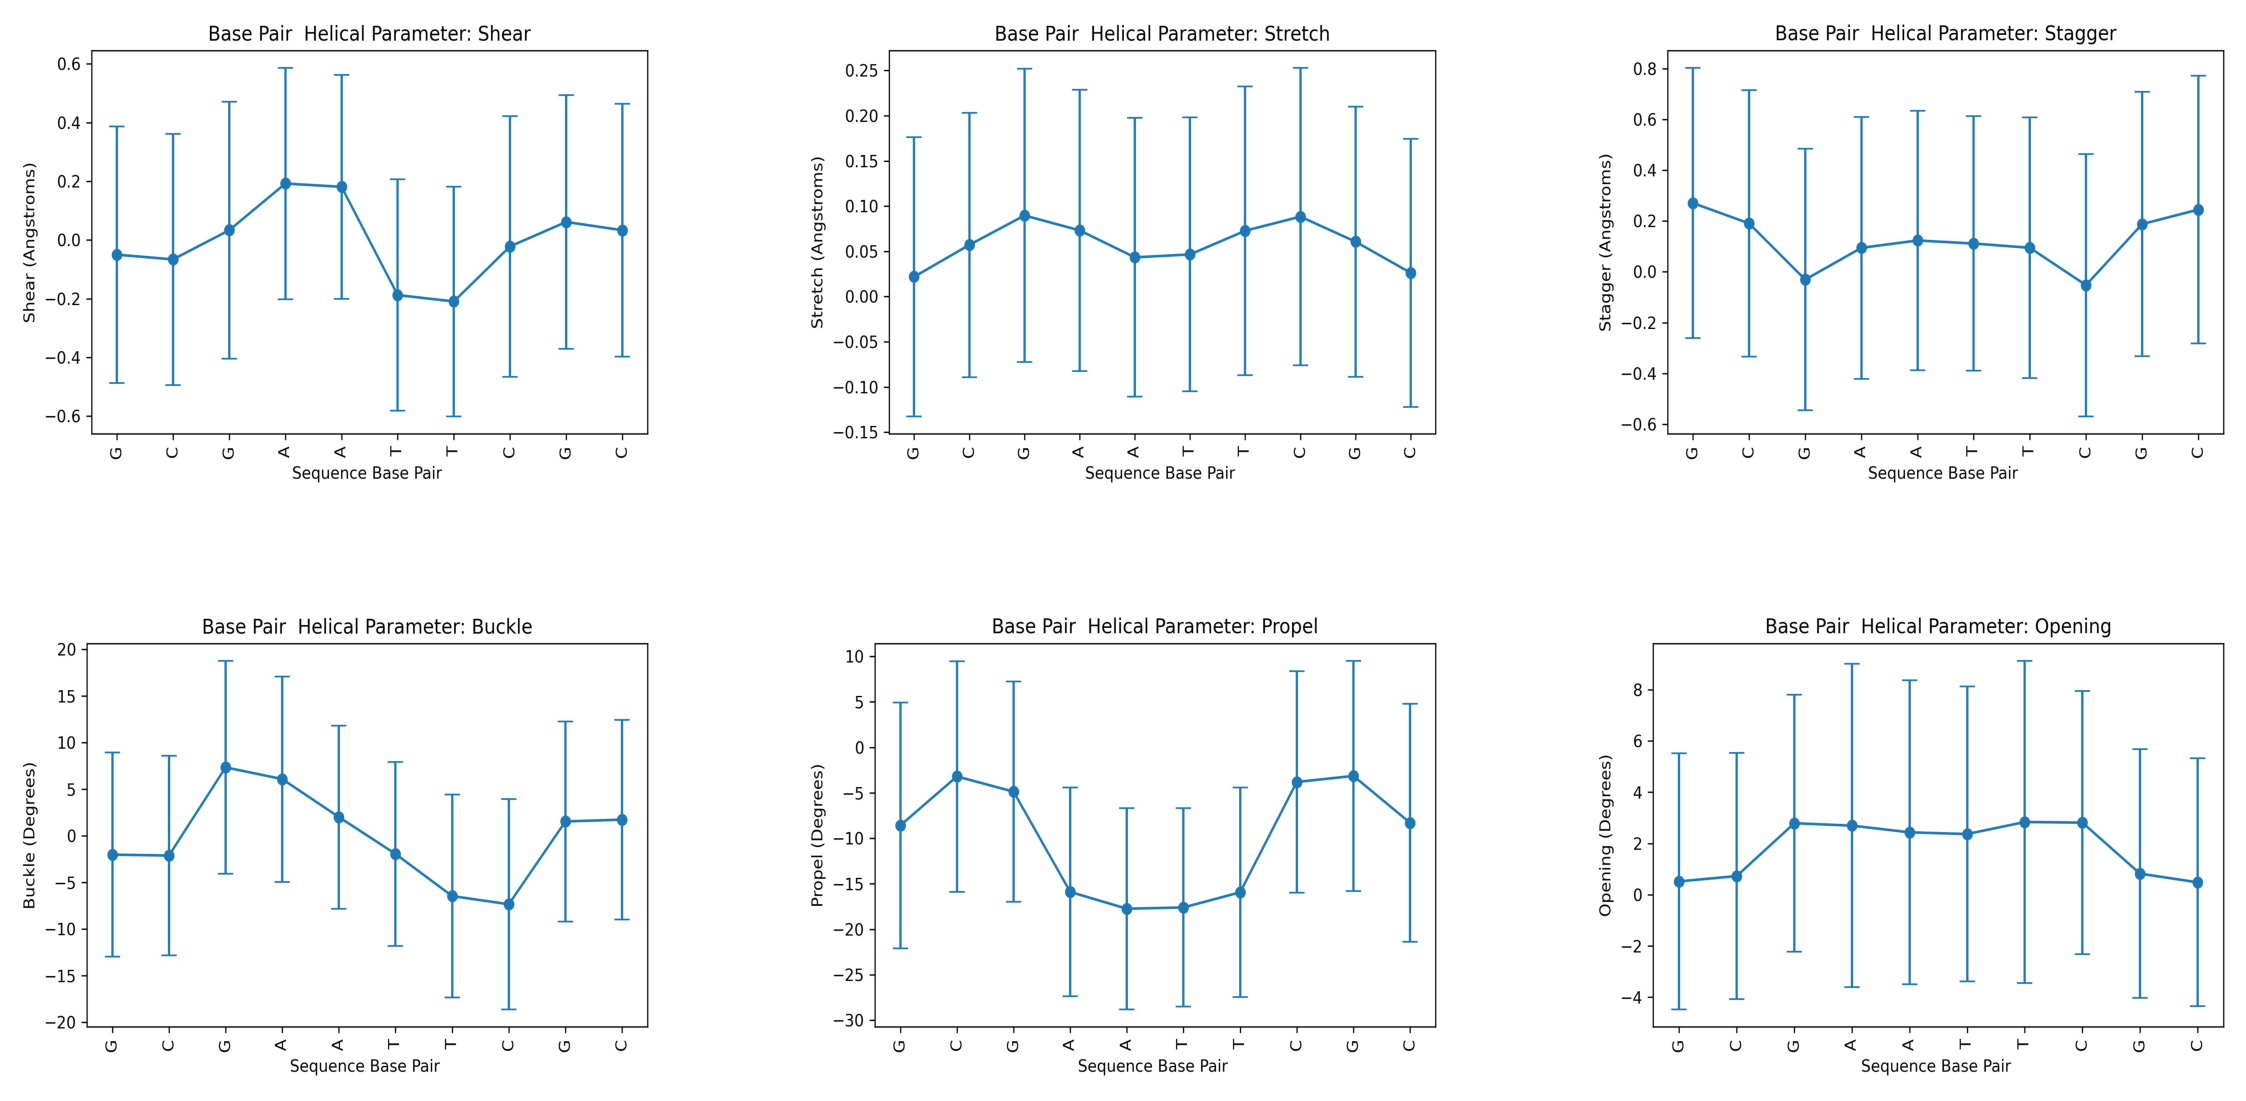

In [18]:
images = []
for helpar in base_pair:
    images.append(helpar + '.averages.jpg')

f, axarr = plt.subplots(2, 3, figsize=(40, 20))

for i, image in enumerate(images):
    y = i%3
    x = int(i/3)

    img = mpimg.imread(image)

    axarr[x,y].imshow(img, aspect='auto')
    axarr[x,y].axis('off')

plt.show()

<a id="avg_axis"></a>
### Axis Base Pair Parameters

***
**Translational (x/y-displacement)** and **rotational (inclination, tip)** parameters related to a dinucleotide Base Pair.

- **X-displacement**: Translation around the X-axis.
- **Y-displacement**: Translation around the Y-axis.
- **Inclination**: Rotation around the X-axis.
- **Tip**: Rotation around the Y-axis.
***
<img src="https://mmb.irbbarcelona.org/NAFlex/images/axis-bp.png" alt="Axis Base Pair Parameters"
	title="Axis Base Pair Parameters" width="200" />
***
**Building Block** used:
- [helparaverages](https://biobb-dna.readthedocs.io/en/latest/dna.html#module-dna.dna_averages) from **biobb_dna.dna.averages** 
***

#### Computing average values from all Axis base-pair parameters

In [ ]:
from biobb_dna.dna.dna_averages import helparaverages

for helpar in axis_base_pairs:

    #input_file_path = canal_out + "_" + helpar + ".ser"
    input_file_path = "canal_out/canal_output" + "_" + helpar + ".ser"
    output_averages_csv_path= helpar+'.averages.csv'
    output_averages_jpg_path= helpar+'.averages.jpg'

    prop = {
        'helpar_name': helpar,
        'sequence': seq,
#        'seqpos': [4,3]
    }

    helparaverages(
        input_ser_path=input_file_path,
        output_csv_path=output_averages_csv_path,
        output_jpg_path=output_averages_jpg_path,
        properties=prop)

#### Showing the calculated average values for all Axis base-pair helical parameters

In [ ]:
for helpar in axis_base_pairs:
    output_averages_csv_path= helpar+'.averages.csv'
    df = pd.read_csv(output_averages_csv_path)
    print("Helical Parameter: " + helpar)
    print(df)
    print("---------\n")

#### Plotting the average values for all Axis base-pair helical parameters 

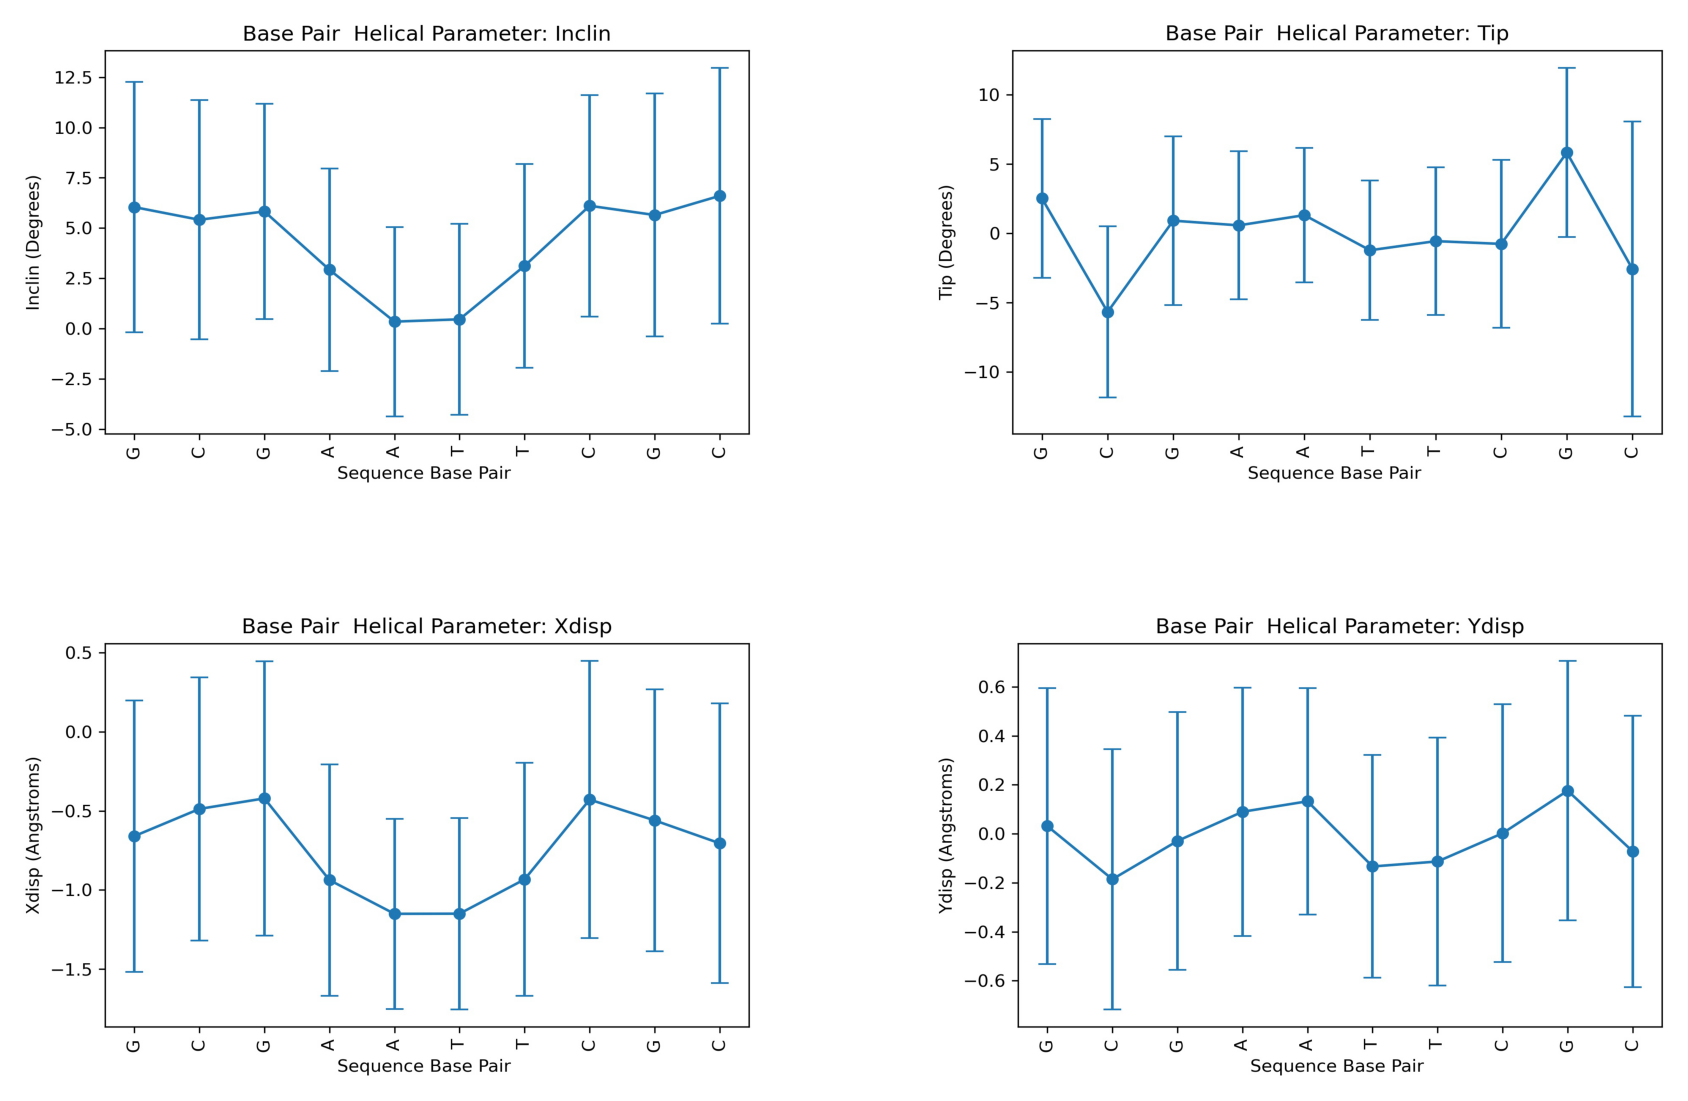

In [21]:
images = []
for helpar in axis_base_pairs:
    images.append(helpar + '.averages.jpg')

f, axarr = plt.subplots(2, 2, figsize=(30, 20))

for i, image in enumerate(images):
    y = i%2
    x = int(i/2)

    img = mpimg.imread(image)

    axarr[x,y].imshow(img, aspect='auto')
    axarr[x,y].axis('off')

plt.show()

<a id="avg_grooves"></a>
### Grooves

***
Nucleic Acid Structure's strand backbones appear closer together on one side of the helix than on the other. This creates a **Major groove** (where backbones are far apart) and a **Minor groove** (where backbones are close together). **Depth and width** of these grooves can be mesured giving information about the different conformations that the nucleic acid structure can achieve.

- **Major Groove Width**.
- **Major Groove Depth**.
- **Minor Groove Width**.
- **Minor Groove Depth**.

***
<img src="https://mmb.irbbarcelona.org//NAFlex2/images/DnaMajorMinorGroove.gif" alt="Grooves Parameters"
	title="Grooves Parameters" width="200" />
***
**Building Block** used:
- [helparaverages](https://biobb-dna.readthedocs.io/en/latest/dna.html#module-dna.dna_averages) from **biobb_dna.dna.dna_averages**
***

#### Computing average values from all Grooves parameters

In [ ]:
from biobb_dna.dna.dna_averages import helparaverages

for helpar in grooves:

    #input_file_path = canal_out + "_" + helpar + ".ser"
    input_file_path = "canal_out/canal_output" + "_" + helpar + ".ser"
    output_averages_csv_path= helpar+'.averages.csv'
    output_averages_jpg_path= helpar+'.averages.jpg'

    prop = {
        'helpar_name': helpar,
        'sequence': seq
    }

    helparaverages(
        input_ser_path=input_file_path,
        output_csv_path=output_averages_csv_path,
        output_jpg_path=output_averages_jpg_path,
        properties=prop)

#### Showing the calculated average values for all Grooves parameters

In [ ]:
for helpar in grooves:
    output_averages_csv_path= helpar+'.averages.csv'
    df = pd.read_csv(output_averages_csv_path)
    print("Helical Parameter: " + helpar)
    print(df)
    print("---------\n")

#### Plotting the average values for all Grooves helical parameters 

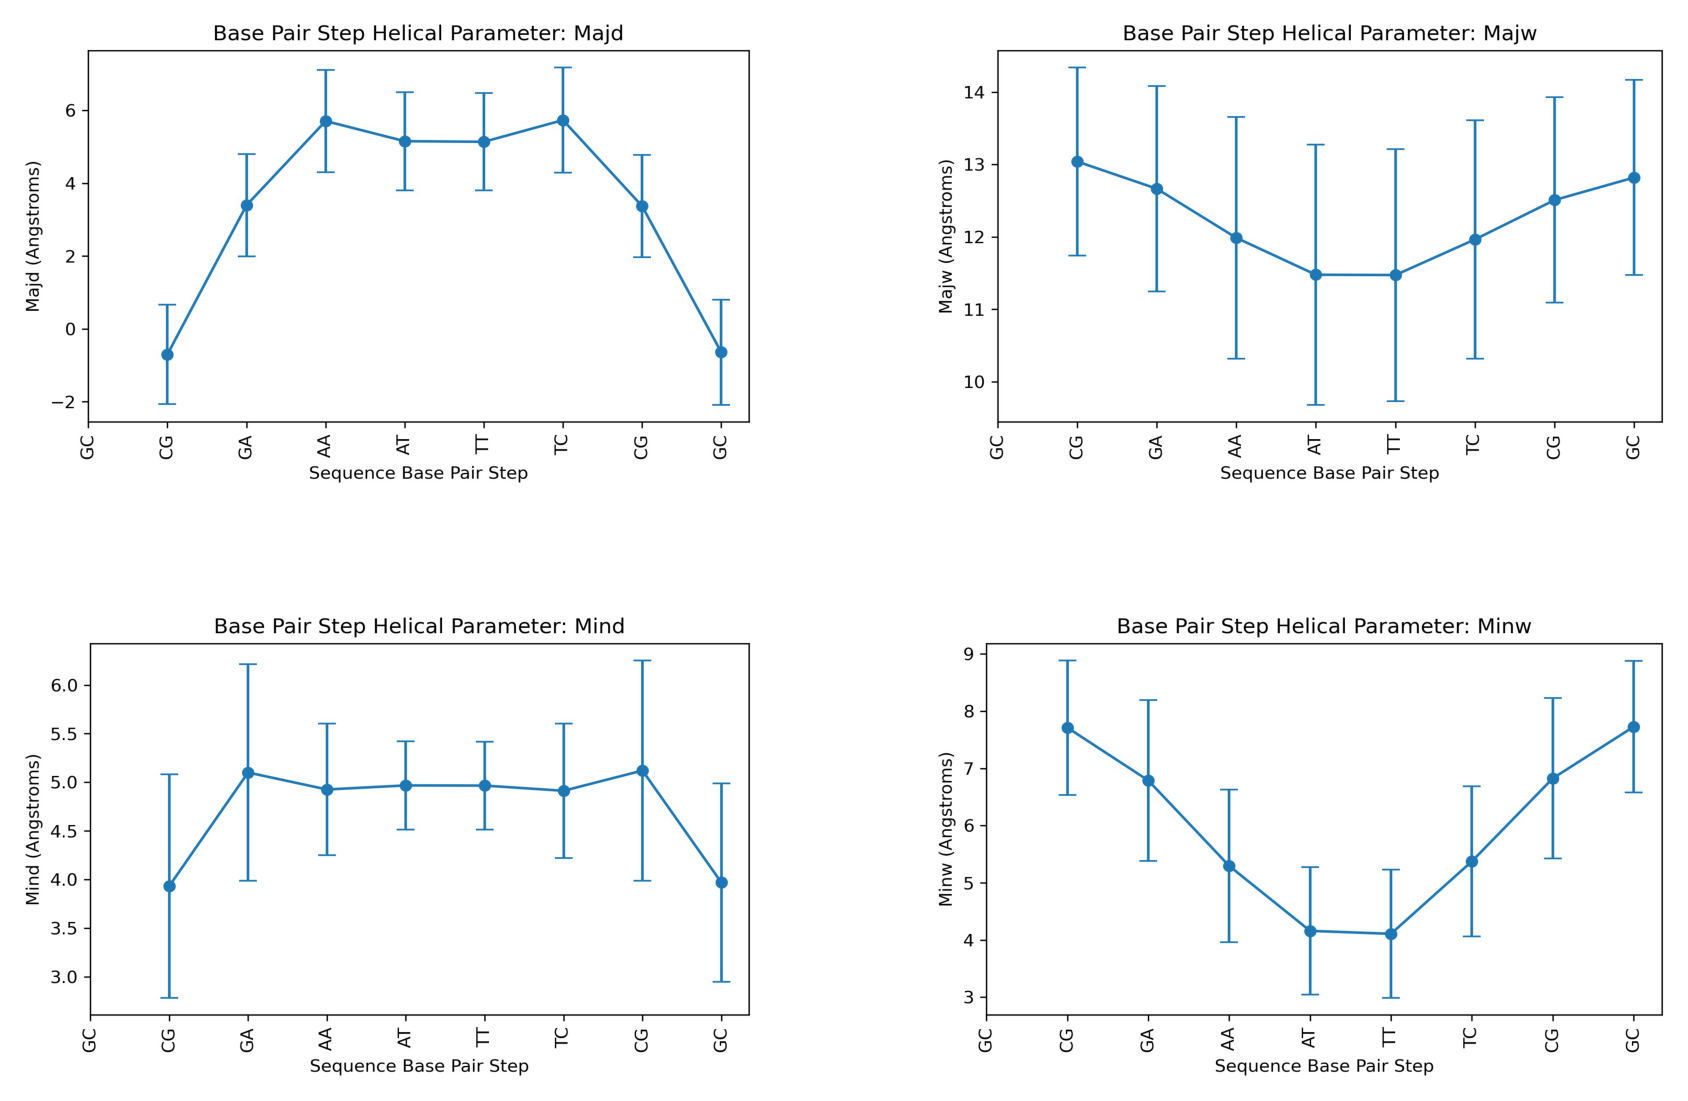

In [24]:
images = []
for helpar in grooves:
    images.append(helpar + '.averages.jpg')

f, axarr = plt.subplots(2, 2, figsize=(30, 20))

for i, image in enumerate(images):
    y = i%2
    x = int(i/2)

    img = mpimg.imread(image)

    axarr[x,y].imshow(img, aspect='auto')
    axarr[x,y].axis('off')

plt.show()

<a id="avg_backbone"></a>
### Backbone Torsions

***

 The three major elements of flexibility in the **backbone** are:

- **[Sugar Puckering](#puckering)**:

    Sugar Puckering annotation is done by dividing the pseudo-rotational circle in four equivalent sections:<br><br>
    - ***North***: 315:45º
    - ***East***: 45:135º
    - ***South***: 135:225º
    - ***West***: 225:315º
    
 These four conformations are those dominating sugar conformational space, in agreement with all available experimental data.


- **[Canonical Alpha/Gamma](#alphagamma)**:

    Rotations around **α/γ torsions** generate non-canonical local conformations leading to a reduced twist and they have been reported as being important in the formation of several protein-DNA complexes. 
    
    
- **[BI/BII Population](#bIbII)**:

    The concerted rotation around **ζ/ε torsions** generates two major conformers: **BI and BII**, which are experimentally known to co-exist in a ratio around 80%:20% (BI:BII) in B-DNA.


<table><tr style="background-color: #FFFFFF"><td>
    <img src="https://mmb.irbbarcelona.org/NAFlex/images/Puckering2.png" alt="Sugar Puckering"
	title="Sugar Puckering" width="300" /> 
</td><td>
    <img src="https://mmb.irbbarcelona.org/NAFlex/images/AlphaGamma.png" alt="Canonical Alpha/Gamma"
title="Canonical Alpha/Gamma" width="300" />
</td><td>
    <img src="https://mmb.irbbarcelona.org/NAFlex/images/BI-BII.png" alt="BI/BII population"
title="BI/BII population" width="300" />
</td></tr>
<tr ><td>
    <p style="text-align: center; font-weight: bold">Sugar Puckering</p>
</td>
<td>
    <p style="text-align: center; font-weight: bold">Canonical Alpha/Gamma</p>
</td>
<td>
    <p style="text-align: center; font-weight: bold">BI/BII population</p>
</td></tr>
</table>
    
***
**Building Blocks** used:
- [puckering](https://biobb-dna.readthedocs.io/en/latest/backbone.html#module-backbone.puckering) from **biobb_dna.backbone.puckering** 
- [canonicalag](https://biobb-dna.readthedocs.io/en/latest/backbone.html#module-backbone.canonicalag) from **biobb_dna.backbone.canonicalag**
- [bipopulations](https://biobb-dna.readthedocs.io/en/latest/backbone.html#module-backbone.bipopulations) from **biobb_dna.backbone.bipopulations**
***

<a id="puckering"></a>

#### Sugar Puckering

##### Computing average values

In [ ]:
from biobb_dna.backbone.puckering import puckering

canal_phaseC = "canal_out/canal_output_phaseC.ser"
canal_phaseW = "canal_out/canal_output_phaseW.ser"

output_puckering_csv_path = 'puckering.averages.csv'
output_puckering_jpg_path = 'puckering.averages.jpg'

prop = {
    'sequence': seq
}

puckering(
    input_phaseC_path=canal_phaseC,
    input_phaseW_path=canal_phaseW,
    output_csv_path=output_puckering_csv_path,
    output_jpg_path=output_puckering_jpg_path,
    properties=prop)

##### Showing the calculated average values

In [26]:
df = pd.read_csv(output_puckering_csv_path)
df

Nucleotide  North   East  West  South
0       C5'-1   1.82   8.84  0.02  89.32
1         G-2   0.10   5.92  0.02  93.96
2         C-3   3.36  20.02  0.00  76.60
3         G-4   0.76   7.52  0.00  91.72
4         A-5   4.16   6.72  0.00  89.10
5         A-6   3.04  16.44  0.00  80.50
6         T-7   1.16  34.06  0.00  64.76
7         T-8   1.50  30.36  0.00  68.10
8         C-9   4.00  24.56  0.00  71.44
9        G-10   0.60   6.40  0.02  92.98
10       C-11   1.72  13.38  0.00  84.90
11     G3'-12   1.18  17.28  0.04  81.50
12          -   0.00   0.00  0.00   0.00
13     G5'-12   3.44  12.72  0.02  83.80
14       C-11   0.16   5.56  0.00  94.24
15       G-10   3.14  20.70  0.00  76.14
16        C-9   0.70   7.32  0.00  91.98
17        T-8   3.64   7.04  0.00  89.32
18        T-7   3.02  14.58  0.02  82.38
19        A-6   0.96  33.82  0.00  65.22
20        A-5   1.00  28.42  0.00  70.58
21        G-4   4.00  23.96  0.02  71.98
22        C-3   0.24   7.14  0.02  92.60
23        G-2   1.72  12.86  0.00  85.40
24      C3'-1   1.40  16.46  0.00  82.12

##### Plotting the average values 

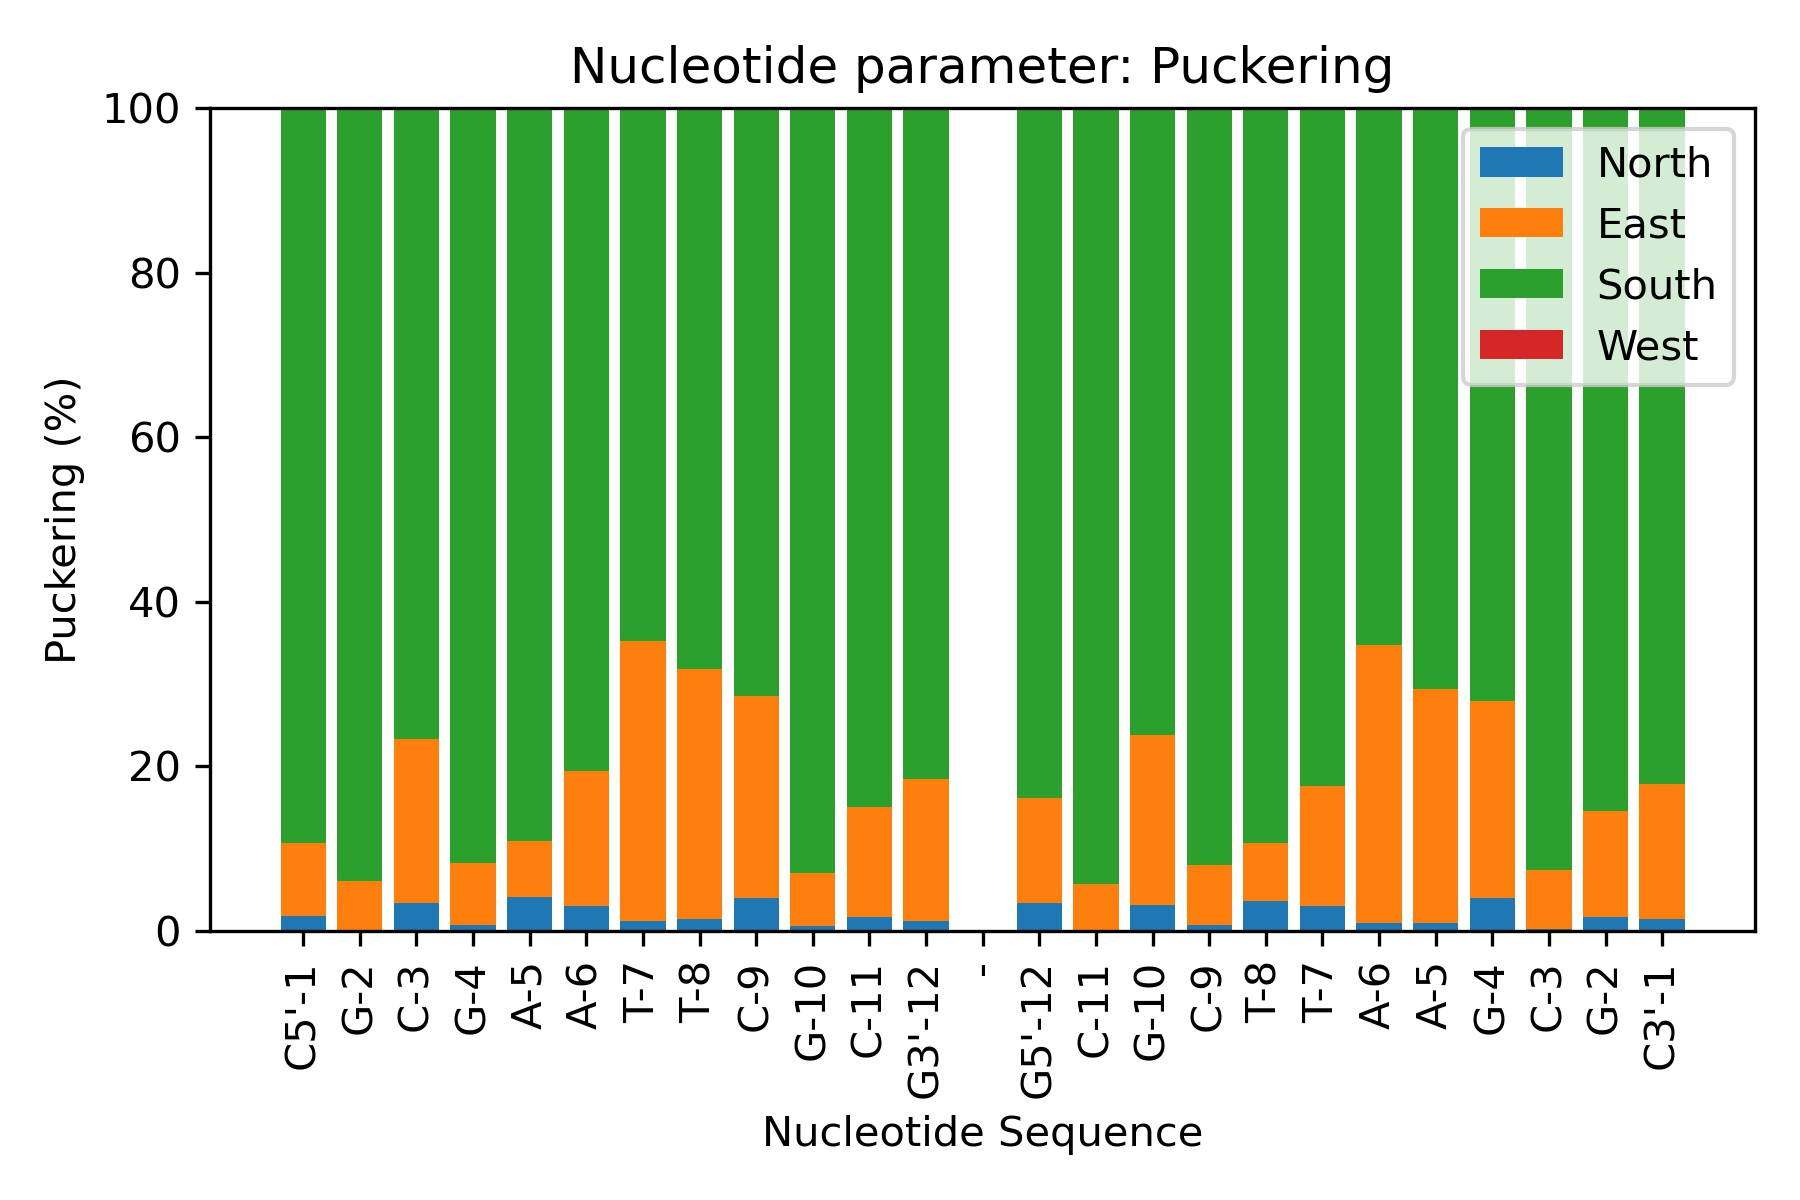

In [27]:
Image(filename=output_puckering_jpg_path,width = 600)

<a id="alphagamma"></a>
#### Canonical Alpha/Gamma

##### Computing average values

In [ ]:
from biobb_dna.backbone.canonicalag import canonicalag

canal_alphaC = "canal_out/canal_output_alphaC.ser"
canal_alphaW = "canal_out/canal_output_alphaW.ser"
canal_gammaC = "canal_out/canal_output_gammaC.ser"
canal_gammaW = "canal_out/canal_output_gammaW.ser"

output_alphagamma_csv_path = 'alphagamma.averages.csv'
output_alphagamma_jpg_path = 'alphagamma.averages.jpg'

prop = {
    'sequence': seq
}

canonicalag(
    input_alphaC_path=canal_alphaC,
    input_alphaW_path=canal_alphaW,
    input_gammaC_path=canal_gammaC,
    input_gammaW_path=canal_gammaW,
    output_csv_path=output_alphagamma_csv_path,
    output_jpg_path=output_alphagamma_jpg_path,
    properties=prop)

##### Showing the calculated average values

In [29]:
df = pd.read_csv(output_alphagamma_csv_path)
df

Nucleotide  Canonical alpha/gamma
0       C5'-1                   0.00
1         G-2                  96.76
2         C-3                  89.66
3         G-4                  92.70
4         A-5                  98.30
5         A-6                  94.52
6         T-7                  99.56
7         T-8                  97.86
8         C-9                  99.54
9        G-10                  99.64
10       C-11                  99.72
11     G3'-12                  98.24
12          -                   0.00
13     G5'-12                   0.00
14       C-11                  95.42
15       G-10                  93.56
16        C-9                  95.40
17        T-8                  99.38
18        T-7                  95.36
19        A-6                  98.28
20        A-5                  96.70
21        G-4                  93.86
22        C-3                  98.70
23        G-2                 100.00
24      C3'-1                  99.78

##### Plotting the average values 

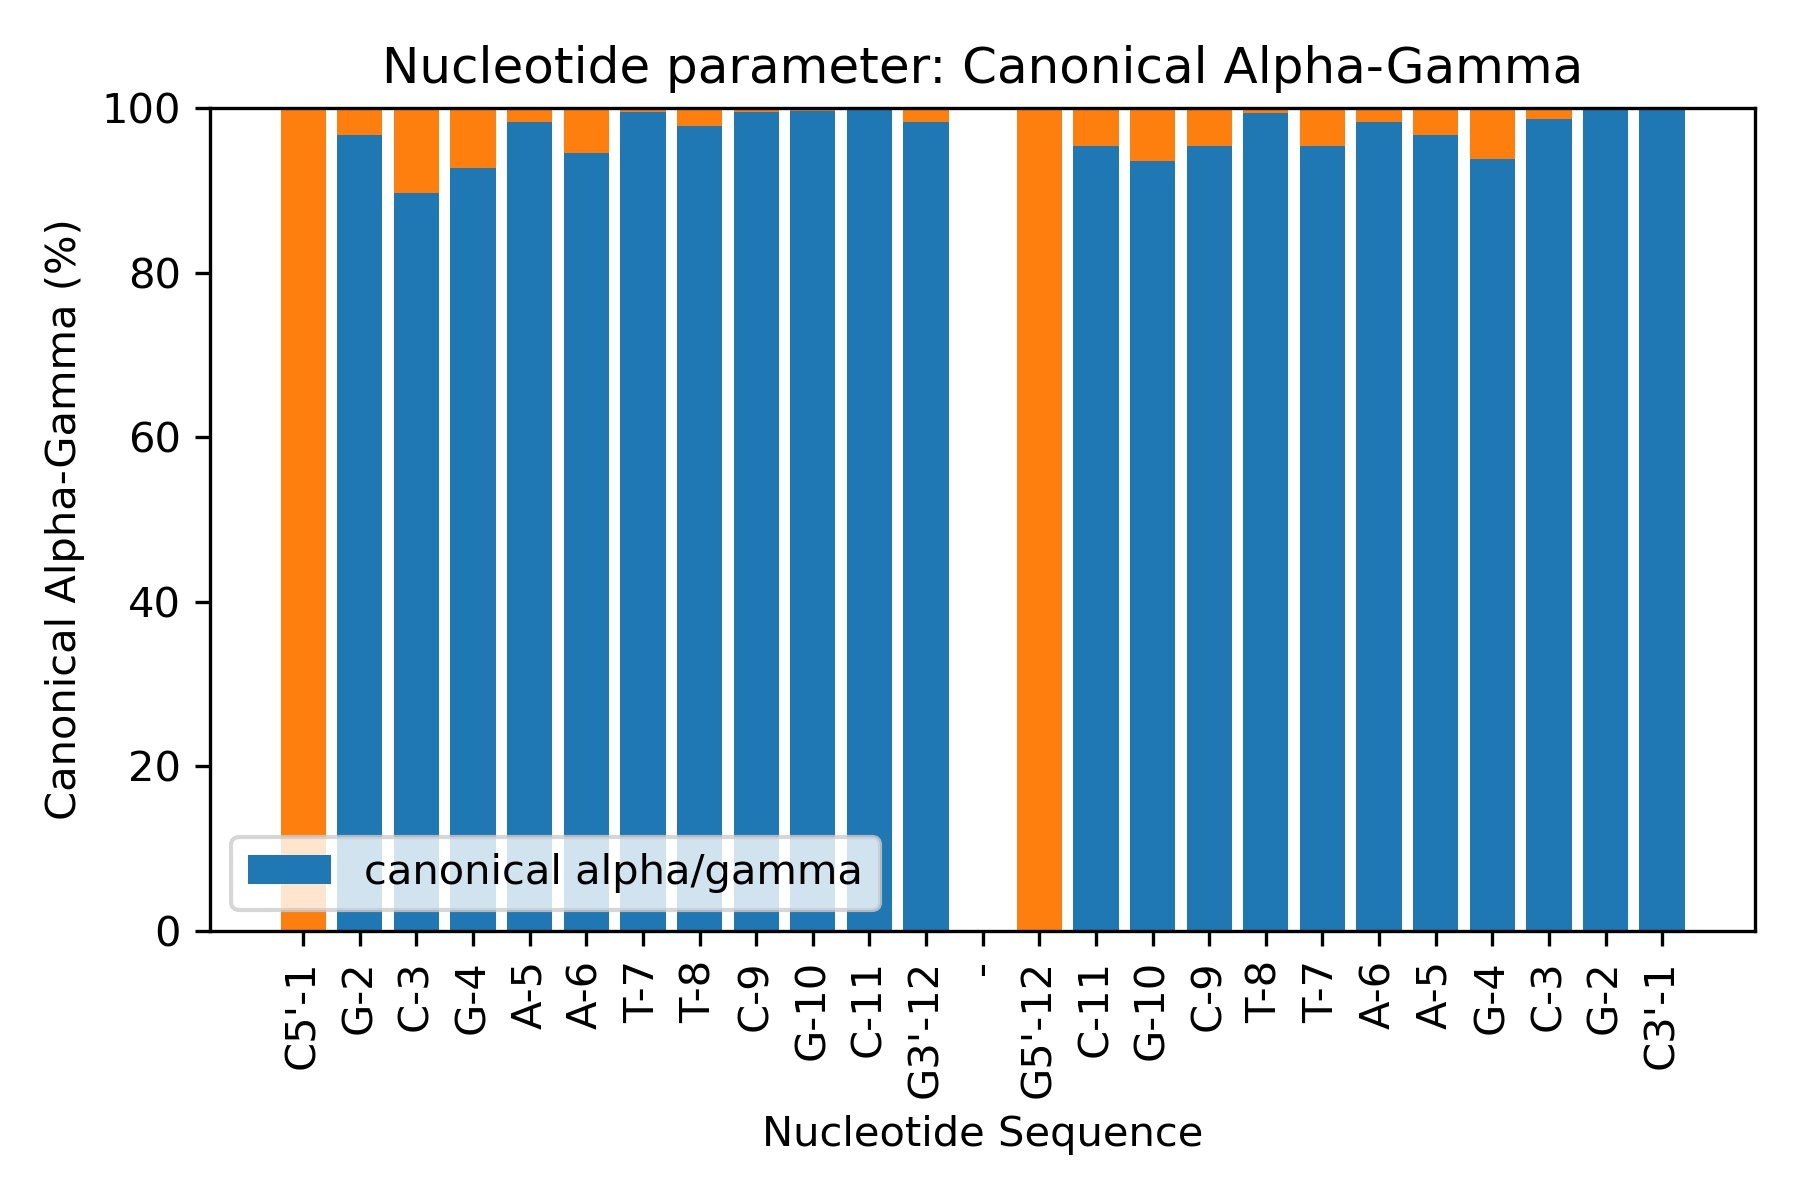

In [30]:
Image(filename=output_alphagamma_jpg_path,width = 600)

<a id="bIbII"></a>
#### BI/BII Population

##### Computing average values

In [ ]:
from biobb_dna.backbone.bipopulations import bipopulations

canal_epsilC = "canal_out/canal_output_epsilC.ser"
canal_epsilW = "canal_out/canal_output_epsilW.ser"
canal_zetaC = "canal_out/canal_output_zetaC.ser"
canal_zetaW = "canal_out/canal_output_zetaW.ser"

output_bIbII_csv_path = 'bIbII.averages.csv'
output_bIbII_jpg_path = 'bIbII.averages.jpg'

prop = {
    'sequence': seq
}

bipopulations(
    input_epsilC_path=canal_epsilC,
    input_epsilW_path=canal_epsilW,
    input_zetaC_path=canal_zetaC,
    input_zetaW_path=canal_zetaW,
    output_csv_path=output_bIbII_csv_path,
    output_jpg_path=output_bIbII_jpg_path,
    properties=prop)


##### Showing the calculated average values

In [32]:
df = pd.read_csv(output_bIbII_csv_path)
df

Nucleotide  BI population  BII population
0       C5'-1      83.523295       16.476705
1         G-2      74.085183       25.914817
2         C-3      85.982803       14.017197
3         G-4      75.924815       24.075185
4         A-5      67.846431       32.153569
5         A-6      59.588082       40.411918
6         T-7      65.406919       34.593081
7         T-8      75.524895       24.475105
8         C-9      79.504099       20.495901
9        G-10      77.644471       22.355529
10       C-11      82.003599       17.996401
11     G3'-12       0.000000      100.000000
12          -       0.000000      100.000000
13     G5'-12      82.443511       17.556489
14       C-11      73.305339       26.694661
15       G-10      84.483103       15.516897
16        C-9      74.305139       25.694861
17        T-8      67.606479       32.393521
18        T-7      59.568086       40.431914
19        A-6      67.126575       32.873425
20        A-5      76.984603       23.015397
21        G-4      80.243951       19.756049
22        C-3      77.604479       22.395521
23        G-2      81.443711       18.556289
24      C3'-1       0.000000      100.000000

##### Plotting the average values 

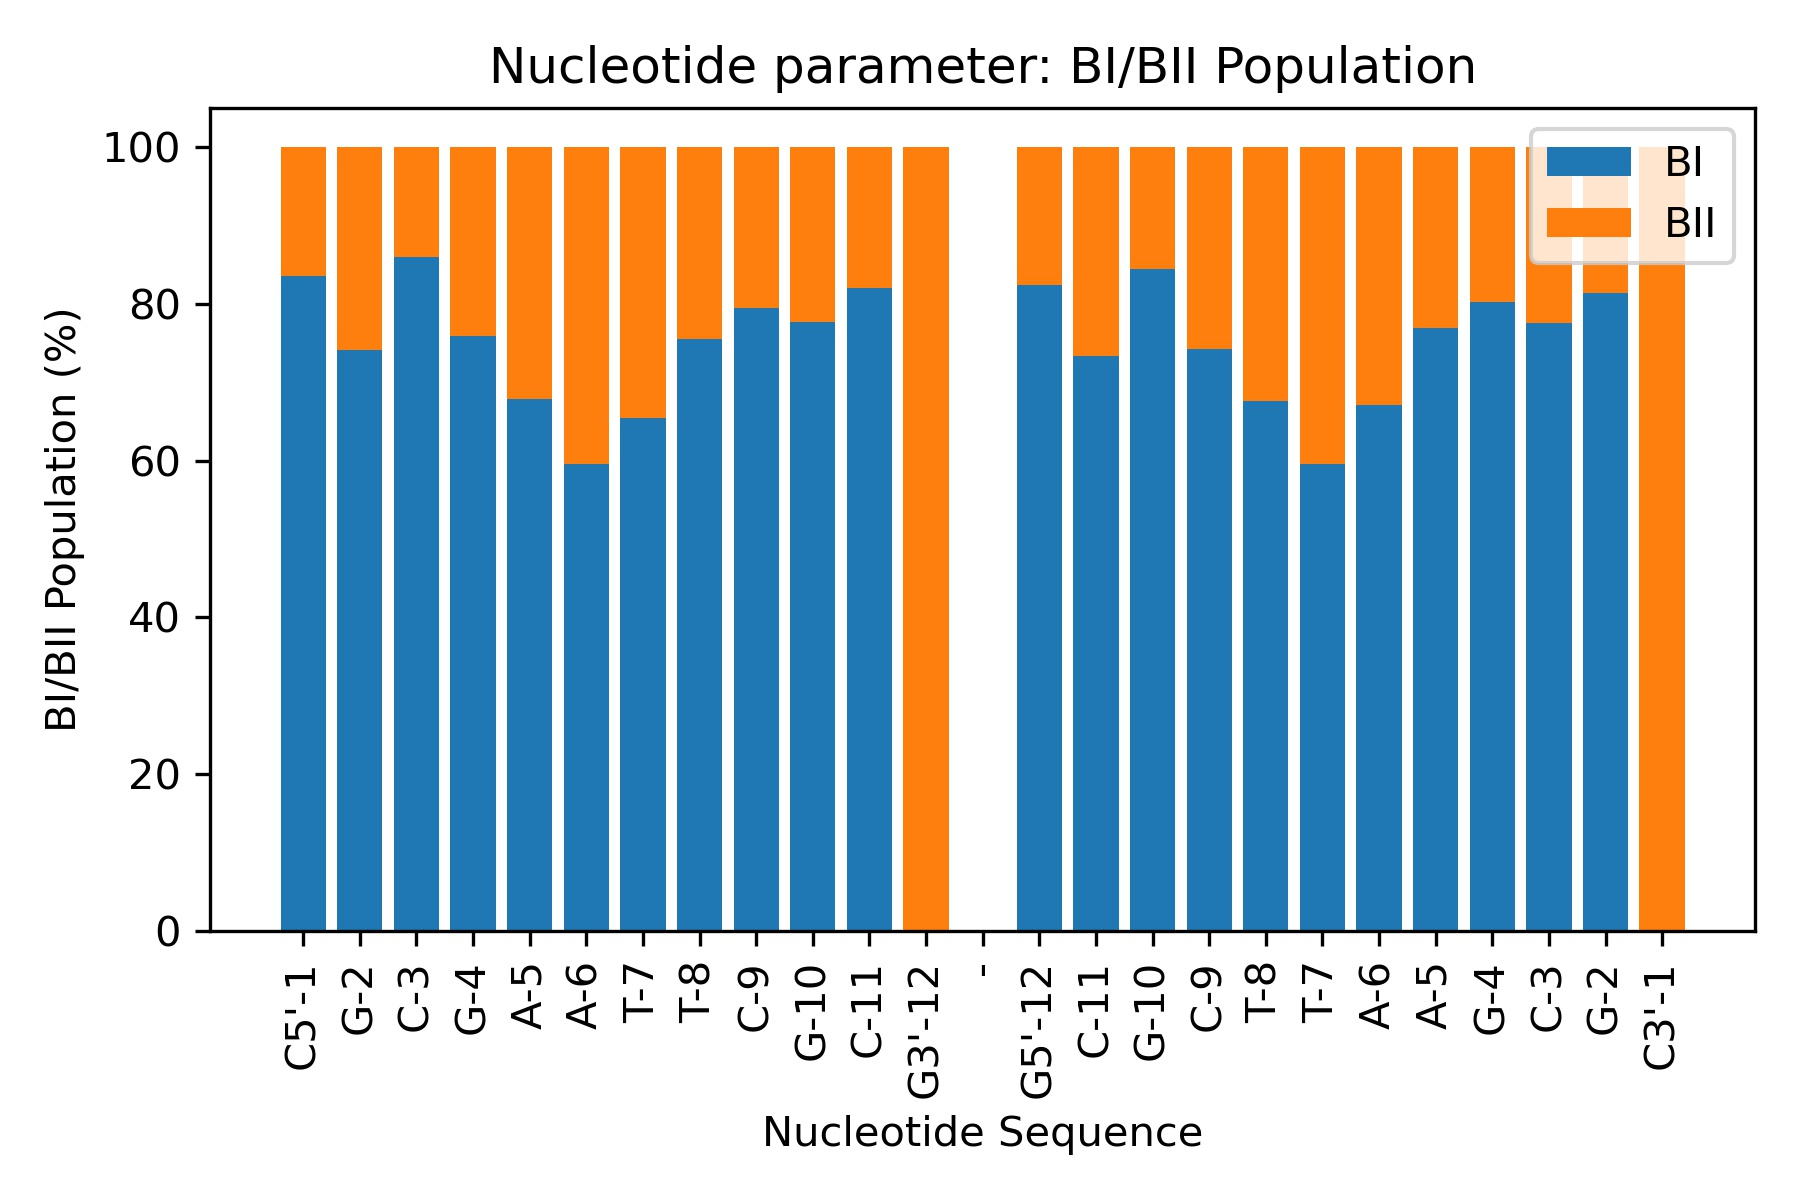

In [33]:
Image(filename=output_bIbII_jpg_path,width = 600)

<a id="timeseries"></a>
## Extracting Time series Helical Parameters

**Time series** values for the set of **helical parameters** can be also extracted from the output of **Curves+/Canal** execution on **Molecular Dynamics Trajectories**. The **helical parameters** can be divided in the same 5 main blocks previously introduced:

- Helical Base Pair Step (Inter-Base Pair) Helical Parameters
- Helical Base Pair (Intra-Base Pair) Helical Parameters
- Axis Base Pair
- Grooves
- Backbone Torsions

***
**Building Block** used:
- [helpartimeseries](https://biobb-dna.readthedocs.io/en/latest/dna.html#module-dna.dna_timeseries) from **biobb_dna.dna.dna_timeseries**
***

### Extracting a particular Helical Parameter

**Time series** values can be extracted from any of the **helical parameters** previously introduced. To illustrate the steps needed, the **base-pair step helical parameter** ***Twist*** has been selected. Please note that computing the **time series** values for a different **helical parameter** just requires modifying the ***helpar*** variable from the next cell.  

In [ ]:
from biobb_dna.dna.dna_timeseries import helpartimeseries

# Modify the next variable to extract time series values for a different helical parameter
# Possible values are: 
    # Base Pair Step (Inter Base Pair) Helical Parameters: shift, slide, rise, tilt, roll, twist 
    # Base Pair (Intra Base Pair) Helical Parameters: shear, stretch, stagger, buckle, propeller, opening
    # Axis Parameters: inclin, tip, xdisp, ydisp
    # Backbone Torsions Parameters: alphaC, alphaW, betaC, betaW, gammaC, gammaW, deltaC, deltaW,
    #                                epsilC, epsilW, zetaC, zetaW, chiC, chiW, phaseC, phaseW
    # Grooves: mind, minw, majd, majw

helpar = "twist" # Modify this variable to extract time series values for a different helical parameter

input_file_path = "canal_out/canal_output" + "_" + helpar + ".ser"
output_timeseries_file_path = helpar + '.timeseries.zip'

prop = {
    'helpar_name': helpar,
    'sequence': seq
}

helpartimeseries(
    input_ser_path=input_file_path,
    output_zip_path=output_timeseries_file_path,
    properties=prop)

### Extracting time series results for the selected helical parameter in a temporary folder

In [35]:
timeseries_dir = "timeseries"

if Path(timeseries_dir).exists(): shutil.rmtree(timeseries_dir) 
os.mkdir(timeseries_dir)

with zipfile.ZipFile(output_timeseries_file_path, 'r') as zip_ref:
    zip_ref.extractall(timeseries_dir)

### Finding out all the possible nucleotide / base / base-pair / base-pair steps

Discover all the possible **nucleotide / base / base-pair / base-pair steps** from the **sequence**. The unit will depend on the helical parameter being studied.  
**Select one of them** to study the **time series** values of the **helical parameter** along the **simulation**.

In [ ]:
helpartimesfiles = glob.glob(timeseries_dir + "/*series*.csv") 

helpartimes = []
for file in helpartimesfiles:
    new_string = file.replace(timeseries_dir + "/series_" + helpar + "_", "")
    new_string = new_string.replace(".csv" , "")
    helpartimes.append(new_string)
    
timesel = ipywidgets.Dropdown(
    options=helpartimes,
    description='Sel. BPS:',
    disabled=False,
)
display(timesel)

### Showing the time series values for the selected unit

In [37]:
file_ser = timeseries_dir + "/series_" + helpar + "_" + timesel.value + ".csv"

df = pd.read_csv(file_ser)
df

Unnamed: 0   6_TT
0              0  24.83
1              1  36.78
2              2  41.00
3              3  33.50
4              4  29.68
...          ...    ...
4995        4995  42.40
4996        4996  44.61
4997        4997  39.61
4998        4998  36.93
4999        4999  36.63

[5000 rows x 2 columns]

In [38]:
file_hist = timeseries_dir + "/hist_" + helpar + "_" + timesel.value + ".csv"

df = pd.read_csv(file_hist)
df

twist  density
0   14.410000      1.0
1   15.203617      0.0
2   15.997234      2.0
3   16.790851      1.0
4   17.584468      1.0
5   18.378085      1.0
6   19.171702      5.0
7   19.965319      3.0
8   20.758936      5.0
9   21.552553     11.0
10  22.346170     10.0
11  23.139787     21.0
12  23.933404     20.0
13  24.727021     34.0
14  25.520638     43.0
15  26.314255     61.0
16  27.107872     80.0
17  27.901489     91.0
18  28.695106    114.0
19  29.488723    138.0
20  30.282340    176.0
21  31.075957    181.0
22  31.869574    208.0
23  32.663191    248.0
24  33.456809    265.0
25  34.250426    280.0
26  35.044043    300.0
27  35.837660    327.0
28  36.631277    321.0
29  37.424894    304.0
30  38.218511    270.0
31  39.012128    298.0
32  39.805745    243.0
33  40.599362    234.0
34  41.392979    196.0
35  42.186596    169.0
36  42.980213    115.0
37  43.773830     78.0
38  44.567447     47.0
39  45.361064     39.0
40  46.154681     18.0
41  46.948298     17.0
42  47.741915     10.0
43  48.535532      9.0
44  49.329149      2.0
45  50.122766      1.0
46  50.916383      2.0

### Plotting the time series values for the selected base-pair step 

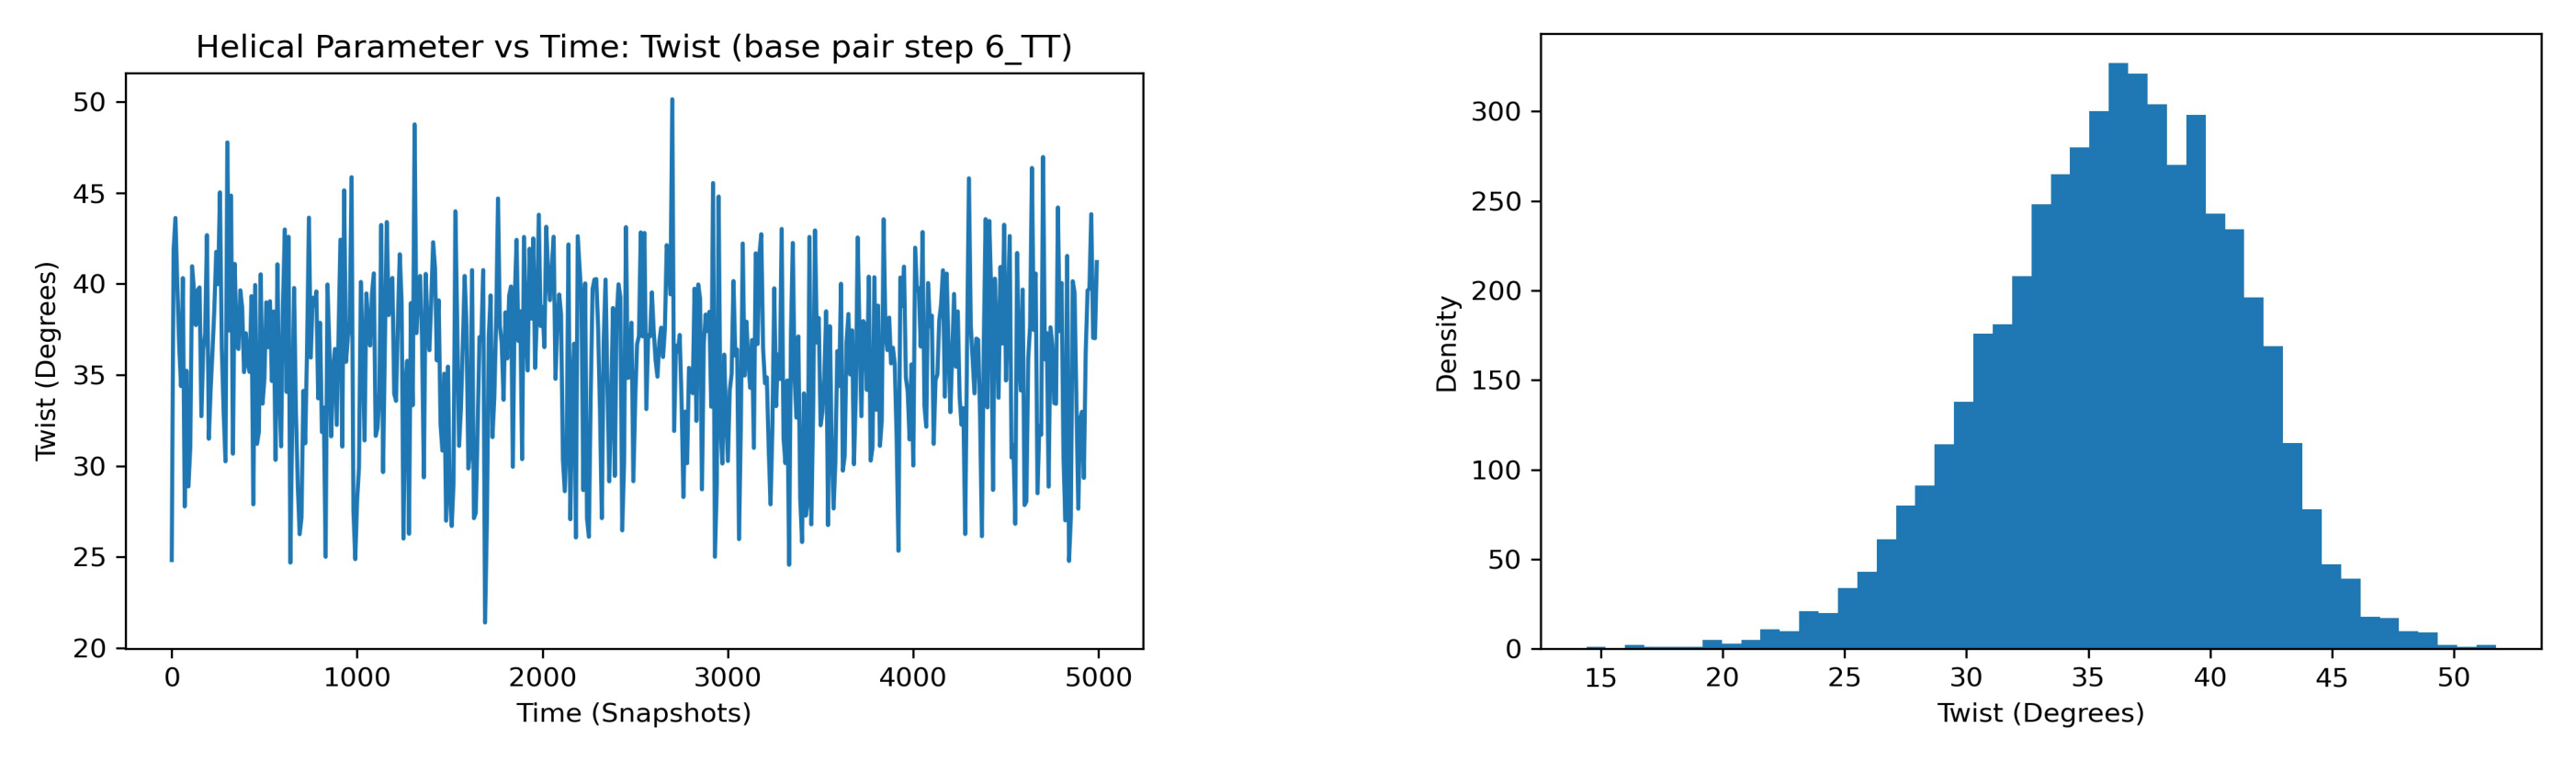

In [39]:
file_ser = timeseries_dir + "/series_" + helpar + "_" + timesel.value + ".jpg"
file_hist = timeseries_dir + "/hist_" + helpar + "_" + timesel.value + ".jpg"

images = []

images.append(file_ser)
images.append(file_hist)

f, axarr = plt.subplots(1, 2, figsize=(50, 15))

for i, image in enumerate(images):
    img = mpimg.imread(image)

    axarr[i].imshow(img, aspect='auto')
    axarr[i].axis('off')

plt.show()

### Computing timeseries for all base-pair step parameters 

In [ ]:
from biobb_dna.dna.dna_timeseries import helpartimeseries

output_timeseries_bps_file_paths = {}
for helpar in base_pair_step:

    input_file_path = "canal_out/canal_output" + "_" + helpar + ".ser"
    output_timeseries_bps_file_paths[helpar] = helpar + '.timeseries.zip'

    prop = {
        'helpar_name': helpar,
        'sequence': seq
    }

    helpartimeseries(
        input_ser_path=input_file_path,
        output_zip_path=output_timeseries_bps_file_paths[helpar],
        properties=prop)

In [41]:
#if Path(timeseries_dir).exists(): shutil.rmtree(timeseries_dir) 
#os.mkdir(timeseries_dir)

for timeseries_zipfile in output_timeseries_bps_file_paths.values():
    with zipfile.ZipFile(timeseries_zipfile, 'r') as zip_ref:
        zip_ref.extractall(timeseries_dir)

### Computing timeseries for all base-pair parameters 

In [ ]:
from biobb_dna.dna.dna_timeseries import helpartimeseries

output_timeseries_bp_file_paths = {}
for helpar in base_pair:

    input_file_path = "canal_out/canal_output" + "_" + helpar + ".ser"
    output_timeseries_bp_file_paths[helpar] = helpar + '.timeseries.zip'

    prop = {
        'helpar_name': helpar,
        'sequence': seq
    }

    helpartimeseries(
        input_ser_path=input_file_path,
        output_zip_path=output_timeseries_bp_file_paths[helpar],
        properties=prop)

In [43]:
#if Path(timeseries_dir).exists(): shutil.rmtree(timeseries_dir) 
#os.mkdir(timeseries_dir)

for timeseries_zipfile in output_timeseries_bp_file_paths.values():
    with zipfile.ZipFile(timeseries_zipfile, 'r') as zip_ref:
        zip_ref.extractall(timeseries_dir)

### Computing timeseries for all axis parameters 

In [ ]:
from biobb_dna.dna.dna_timeseries import helpartimeseries

output_timeseries_bp_file_paths = {}
for helpar in axis_base_pairs:

    input_file_path = "canal_out/canal_output" + "_" + helpar + ".ser"
    output_timeseries_bp_file_paths[helpar] = helpar + '.timeseries.zip'

    prop = {
        'helpar_name': helpar,
        'sequence': seq
    }

    helpartimeseries(
        input_ser_path=input_file_path,
        output_zip_path=output_timeseries_bp_file_paths[helpar],
        properties=prop)

In [45]:
for timeseries_zipfile in output_timeseries_bp_file_paths.values():
    with zipfile.ZipFile(timeseries_zipfile, 'r') as zip_ref:
        zip_ref.extractall(timeseries_dir)

### Computing timeseries for all grooves parameters 

In [ ]:
from biobb_dna.dna.dna_timeseries import helpartimeseries

output_timeseries_bp_file_paths = {}
for helpar in grooves:

    input_file_path = "canal_out/canal_output" + "_" + helpar + ".ser"
    output_timeseries_bp_file_paths[helpar] = helpar + '.timeseries.zip'

    prop = {
        'helpar_name': helpar,
        'sequence': seq
    }

    helpartimeseries(
        input_ser_path=input_file_path,
        output_zip_path=output_timeseries_bp_file_paths[helpar],
        properties=prop)

In [47]:
for timeseries_zipfile in output_timeseries_bp_file_paths.values():
    with zipfile.ZipFile(timeseries_zipfile, 'r') as zip_ref:
        zip_ref.extractall(timeseries_dir)

### Computing timeseries for all backbone torsions parameters 

In [ ]:
from biobb_dna.dna.dna_timeseries import helpartimeseries

output_timeseries_bp_file_paths = {}
for helpar in backbone_torsions:

    input_file_path = "canal_out/canal_output" + "_" + helpar + ".ser"
    output_timeseries_bp_file_paths[helpar] = helpar + '.timeseries.zip'

    prop = {
        'helpar_name': helpar,
        'sequence': seq
    }

    helpartimeseries(
        input_ser_path=input_file_path,
        output_zip_path=output_timeseries_bp_file_paths[helpar],
        properties=prop)

In [49]:
for timeseries_zipfile in output_timeseries_bp_file_paths.values():
    with zipfile.ZipFile(timeseries_zipfile, 'r') as zip_ref:
        zip_ref.extractall(timeseries_dir)

<a id="stiffness"></a>
## Stiffness

**Molecular stiffness** is an **elastic force constant** associated with **helical deformation** at the **base pair step** level and is determined by inversion of the covariance matrix in helical space, which yields **stiffness matrices** whose diagonal elements provide the **stiffness constants** associated with **pure rotational** (twist, roll and tilt) and **translational** (rise, shift and slide) **deformations** within the given step.

***
<img src="https://mmb.irbbarcelona.org/NAFlex2/images/StiffnessMatrix.png" alt="Stiffness Matrix"
	title="Stiffness Matrix" width="500" />
***
**Building Blocks** used:
- [averagestiffness](https://biobb-dna.readthedocs.io/en/latest/stiffness.html#module-stiffness.average_stiffness) from **biobb_dna.stiffness.average_stiffness** 
- [bpstiffness](https://biobb-dna.readthedocs.io/en/latest/stiffness.html#module-stiffness.basepair_stiffness) from **biobb_dna.stiffness.basepair_stiffness** 
***


In [ ]:
from biobb_dna.stiffness.average_stiffness import averagestiffness

helpar = "twist" # Modify this variable to extract time series values for a different helical parameter

input_file_path = "canal_out/canal_output" + "_" + helpar + ".ser"
output_stiffness_csv_path = helpar + '.stiffness.csv'
output_stiffness_jpg_path = helpar + '.stiffness.jpg'

prop = { 
    'sequence' : seq
}

averagestiffness(
    input_ser_path=input_file_path,
    output_csv_path=output_stiffness_csv_path,
    output_jpg_path=output_stiffness_jpg_path,
    properties=prop)


In [51]:
df = pd.read_csv(output_stiffness_csv_path)
df

Unnamed: 0  twist_stiffness
0         GC         0.029784
1         CG         0.018300
2         GA         0.028595
3         AA         0.033391
4         AT         0.057062
5         TT         0.031410
6         TC         0.029772
7         CG         0.019181
8         GC         0.031688
9         CG         0.005167

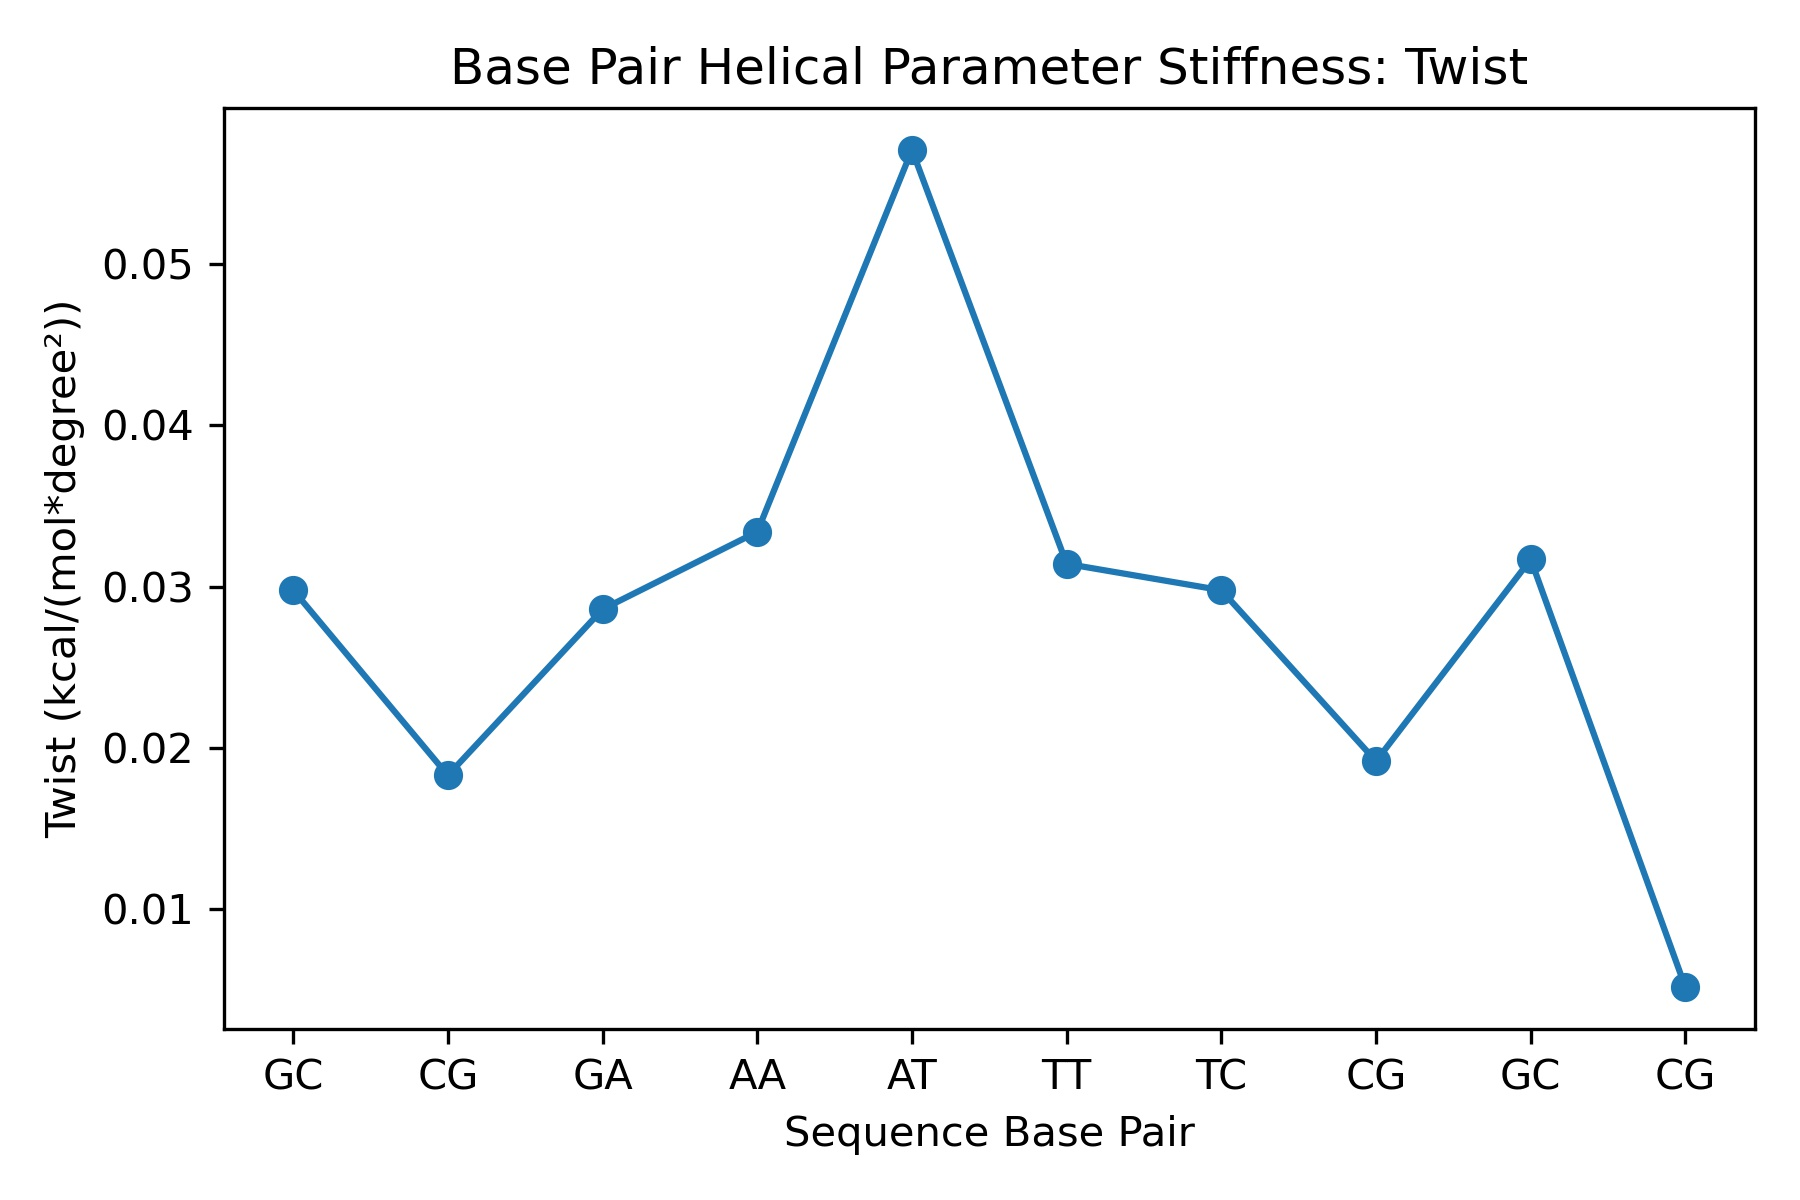

In [52]:
Image(filename=output_stiffness_jpg_path,width = 600)

In [ ]:
from biobb_dna.stiffness.basepair_stiffness import bpstiffness

timeseries_shift = timeseries_dir+"/series_shift_" + timesel.value + ".csv"
timeseries_slide = timeseries_dir+"/series_slide_" + timesel.value + ".csv"
timeseries_rise = timeseries_dir+"/series_rise_" + timesel.value + ".csv"
timeseries_tilt = timeseries_dir+"/series_tilt_" + timesel.value + ".csv"
timeseries_roll = timeseries_dir+"/series_roll_" + timesel.value + ".csv"
timeseries_twist = timeseries_dir+"/series_twist_" + timesel.value + ".csv"

output_stiffness_bps_csv_path = "stiffness_bps.csv"
output_stiffness_bps_jpg_path = "stiffness_bps.jpg"

bpstiffness(
    input_filename_shift=timeseries_shift,
    input_filename_slide=timeseries_slide,
    input_filename_rise=timeseries_rise,
    input_filename_tilt=timeseries_tilt,
    input_filename_roll=timeseries_roll,
    input_filename_twist=timeseries_twist,
    output_csv_path=output_stiffness_bps_csv_path,
    output_jpg_path=output_stiffness_bps_jpg_path)

In [54]:
df = pd.read_csv(output_stiffness_bps_csv_path)
df

6_TT     shift     slide      rise      tilt      roll     twist
0  shift  1.565629 -0.750135 -0.335147 -0.263984 -0.153248 -0.220935
1  slide -0.750135  3.535266  1.335823 -0.095199 -0.287142 -2.104566
2   rise -0.335147  1.335823  5.158742  0.637038  0.415877 -1.293672
3   tilt -0.024904 -0.008981  0.060098  0.235447  0.015406 -0.008404
4   roll -0.014457 -0.027089  0.039234  0.015406  0.119149  0.038313
5  twist -0.020843 -0.198544 -0.122045 -0.008404  0.038313  0.412179

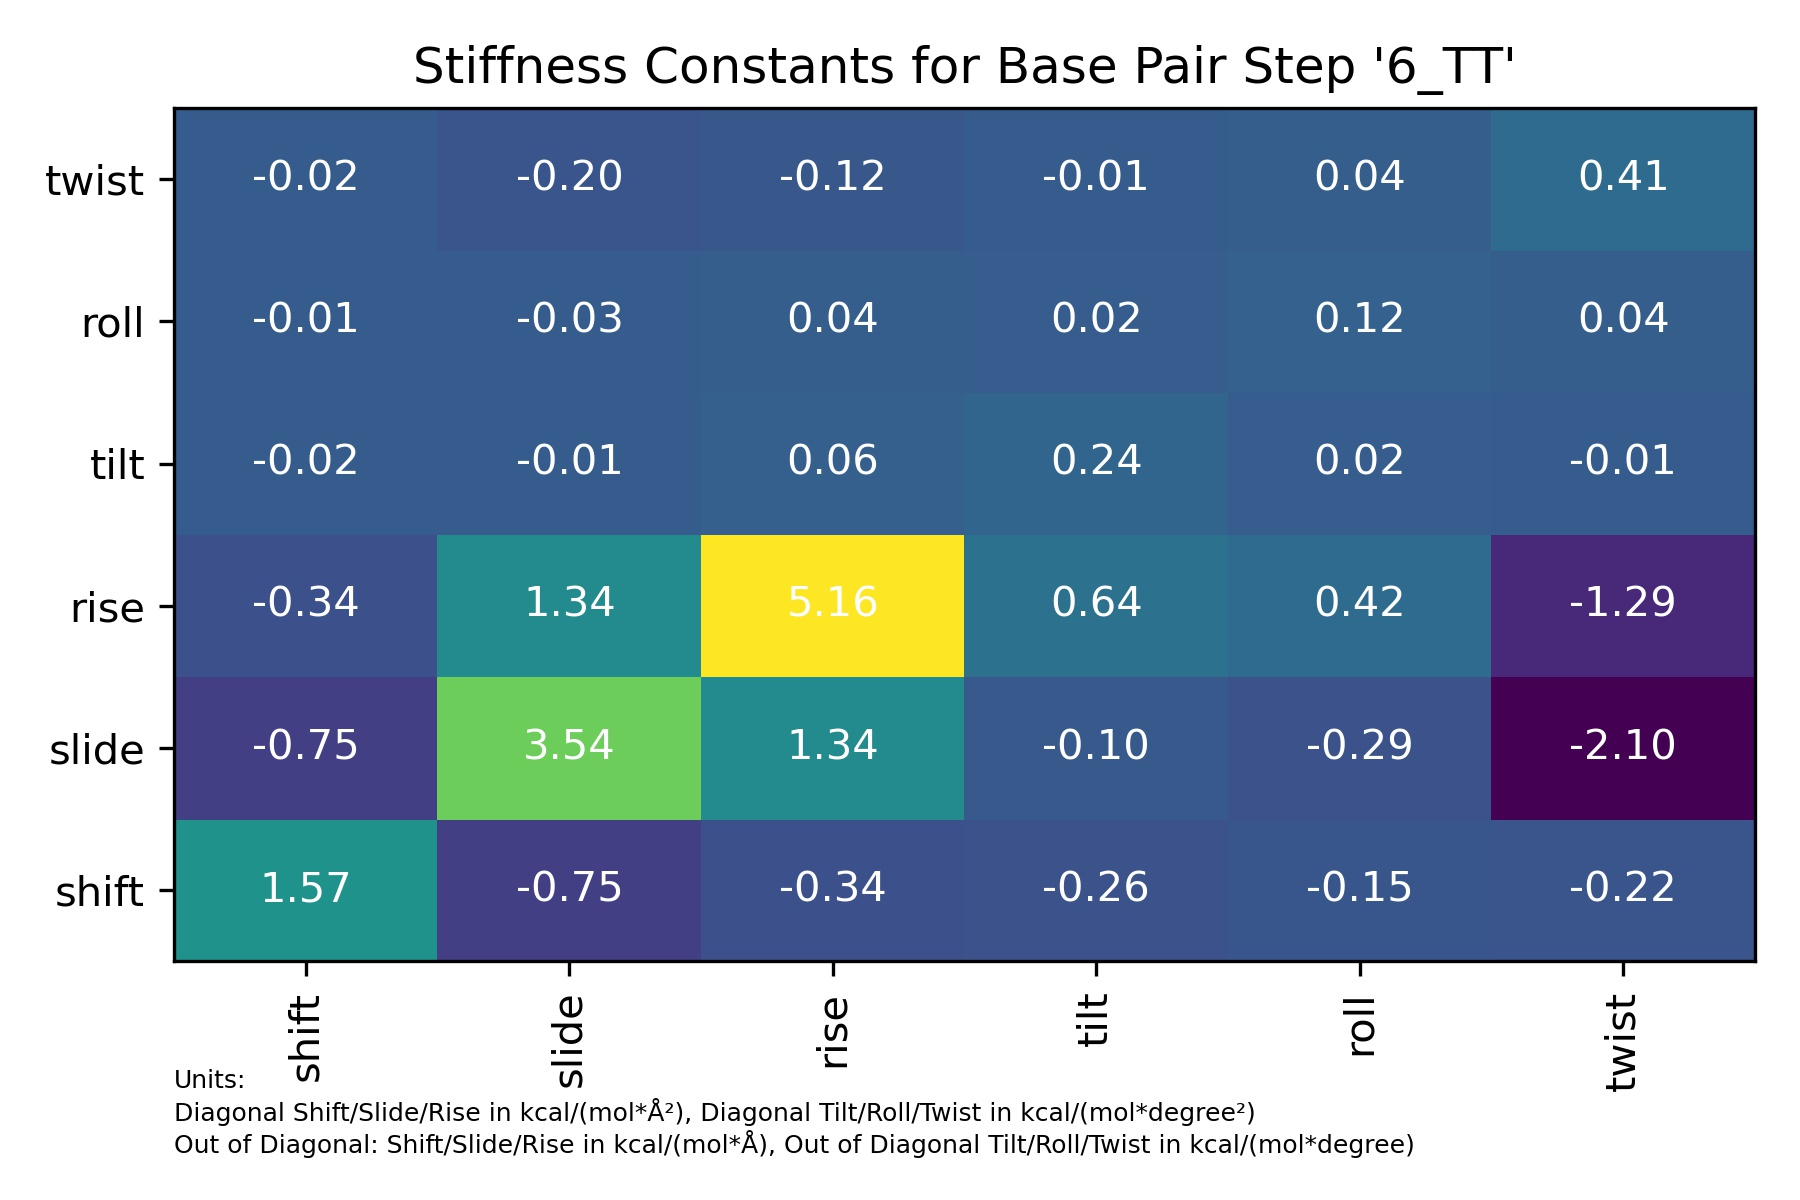

In [55]:
Image(filename=output_stiffness_bps_jpg_path,width = 600)

<a id="bimodality"></a>
## Bimodality

**Base-pair steps** helical parameters usually follow a normal (Gaussian-like) distribution. However, recent studies observed **bimodal distributions** in some **base-pair steps** for **twist and slide**, highlighting potential caveats on the **harmonic approximation** implicit in **elastic analysis** and mesoscopic models of DNA flexibility.

***
<img src="https://mmb.irbbarcelona.org/BIGNASim/htmlib/help/img/Tut3_GCGA_Twist_plot.png" alt="Twist bimodality"
	title="Twist bimodality" width="600" />
***

**μABC: a systematic microsecond molecular dynamics study of tetranucleotide sequence effects in B-DNA**
*Marco Pasi, John H Maddocks, David Beveridge, Thomas C Bishop, David A Case, Thomas Cheatham 3rd, Pablo D Dans, B Jayaram, Filip Lankas, Charles Laughton, Jonathan Mitchell, Roman Osman, Modesto Orozco, Alberto Pérez, Daiva Petkevičiūtė, Nada Spackova, Jiri Sponer, Krystyna Zakrzewska, Richard Lavery*
***Nucleic Acids Research 2014, Volume 42, Issue 19, Pages 12272-12283***<br>
https://doi.org/10.1093/nar/gku855

**Exploring polymorphisms in B-DNA helical conformations**<br>
*Pablo D Dans, Alberto Pérez, Ignacio Faustino, Richard Lavery, Modesto Orozco*<br>
***Nucleic Acids Research 2012, Volume 40, Issue 21, Pages 10668-10678***<br>
https://doi.org/10.1093/nar/gks884

**A systematic molecular dynamics study of nearest-neighbor effects on base pair and base pair step conformations and fluctuations in B-DNA**<br>
*Lavery R, Zakrzewska K, Beveridge D, Bishop TC, Case DA, Cheatham T, III, Dixit S, Jayaram B, Lankas F, Laughton C, John H Maddocks, Alexis Michon, Roman Osman, Modesto Orozco, Alberto Perez, Tanya Singh, Nada Spackova, Jiri Sponer*<br>
***Nucleic Acids Research 2010, Volume 38, Pages 299–313***<br>
https://doi.org/10.1093/nar/gkp834

***

**Building Block** used:
- [helparbimodality](https://biobb-dna.readthedocs.io/en/latest/dna.html#module-dna.dna_bimodality) from **biobb_dna.dna.bimodality** 
***

In [ ]:
from biobb_dna.dna.dna_bimodality import helparbimodality

helpar = "twist"
input_csv = timeseries_dir+"/series_"+helpar+"_"+timesel.value+'.csv'
#input_csv = "/Users/hospital/biobb_tutorials/biobb_dna/timeseries"+"/series_"+timesel.value+'.csv' # <-- TO BE REPLACED BY PREVIOUS LINE 

output_bimodality_csv = helpar+'.bimodality.csv'
output_bimodality_jpg = helpar+'.bimodality.jpg'

prop = {
    'max_iter': 500
}
helparbimodality(
    input_csv_file=input_csv,
    output_csv_path=output_bimodality_csv,
    output_jpg_path=output_bimodality_jpg,
    properties=prop)

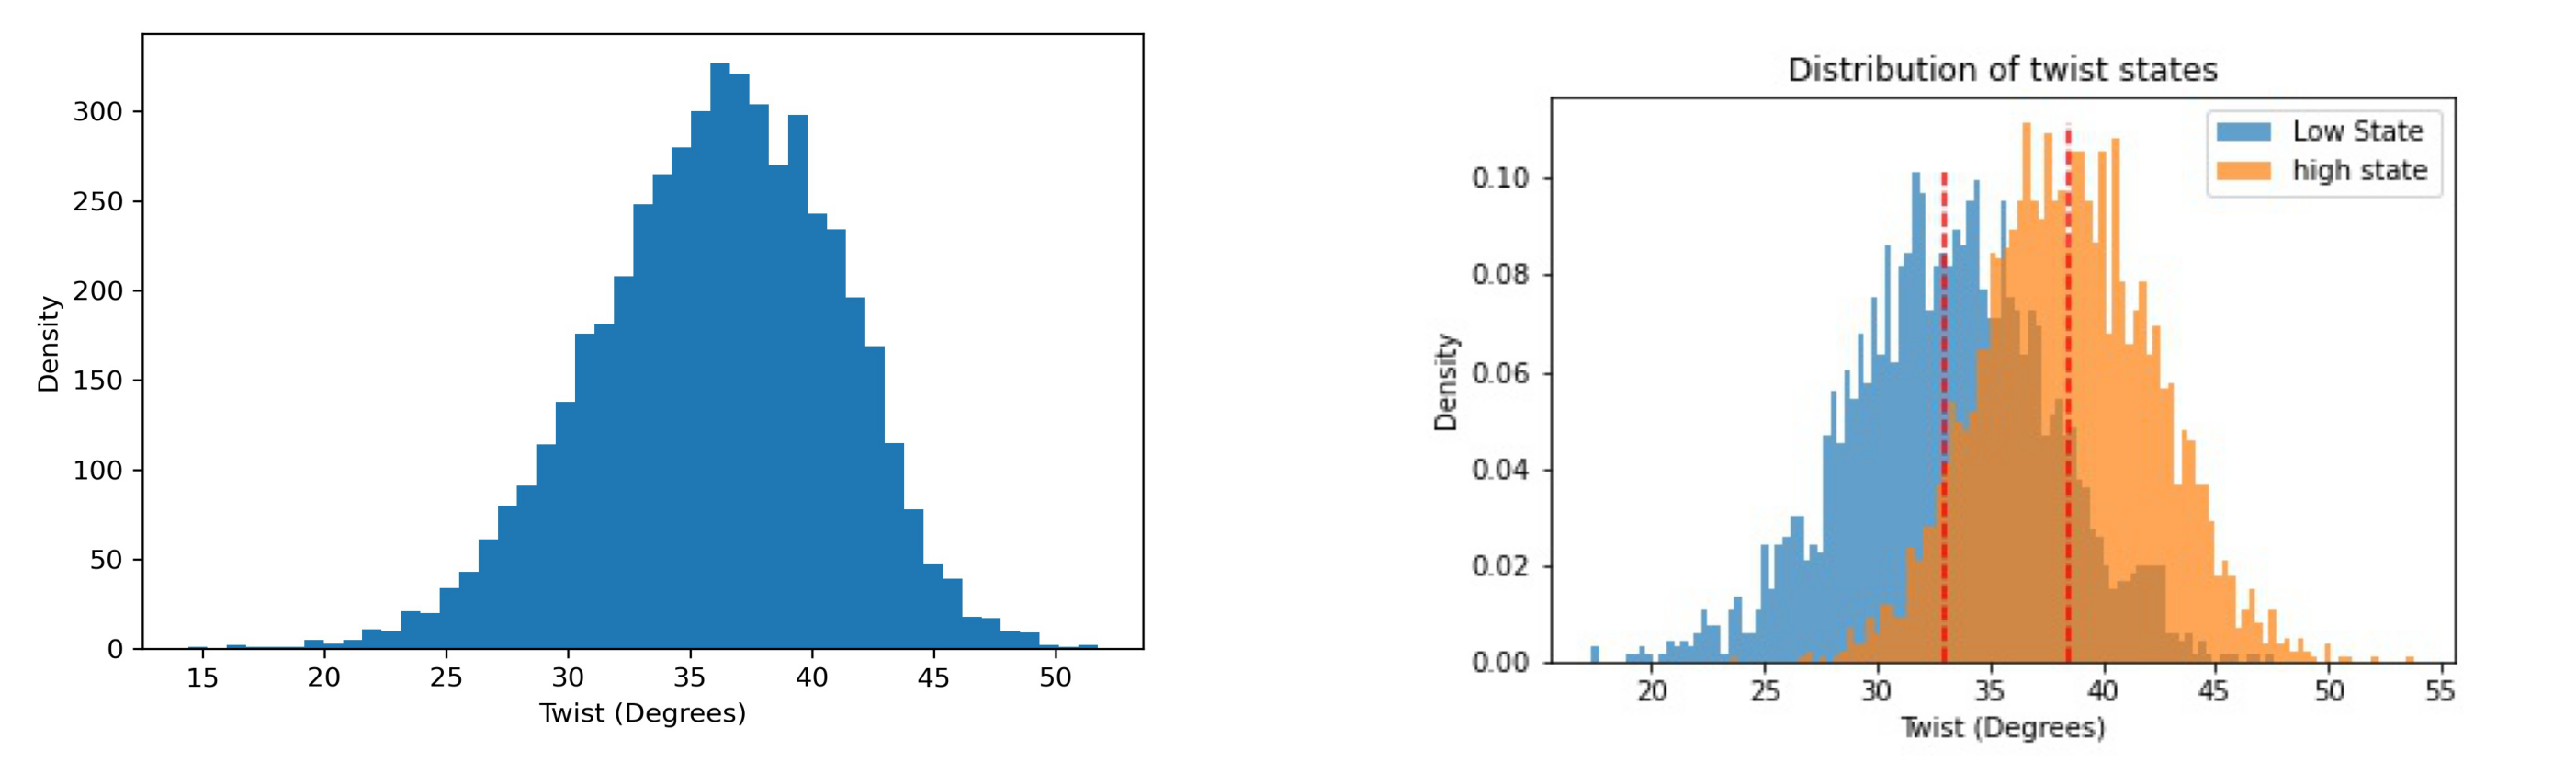

In [57]:
file_hist = timeseries_dir + "/hist_" + helpar + "_" + timesel.value + ".jpg"
file_bi = helpar + ".bimodality.jpg"

images = []

images.append(file_hist)
images.append(file_bi)

f, axarr = plt.subplots(1, 2, figsize=(50, 15))

for i, image in enumerate(images):
    img = mpimg.imread(image)

    axarr[i].imshow(img, aspect='auto')
    axarr[i].axis('off')

plt.show()

<a id="correlations"></a>
## Correlations

Sequence-dependent **correlation movements** have been identified in DNA conformational analysis at the **base pair** and **base pair-step** level. **Trinucleotides** were found to show moderate to high **correlations** in some **intra base pair helical parameter** (e.g. shear-opening, shear-stretch, stagger-buckle). Similarly, some **tetranucleotides** are showing strong **correlations** in their **inter base pair helical parameters** (e.g. shift-tilt, slide-twist, rise-tilt, shift-slide, and shift-twist in RR steps), with **negative correlations** in the shift-slide and roll-twist cases. **Correlations** are also observed in the combination of **inter- and intra-helical parameters** (e.g. shift-opening, rise-buckle, stagger-tilt). **Correlations** analysis can be also extended to **neighboring steps** (e.g. twist in the central YR step of XYRR tetranucleotides with slide in the adjacent RR step). 

- [Sequence Correlations: Intra-base pairs](#intrasequencecorrelation)
- [Sequence Correlations: Inter-base pair steps](#intersequencecorrelation)
- [Helical Parameter Correlations: Intra-base pairs](#intrahelparcorrelation)
- [Helical Parameter Correlations: Inter-base pair steps](#interhelparcorrelation)
- [Neighboring steps Correlations: Intra-base pairs](#intrabasepaircorrelation)
- [Neighboring steps Correlations: Inter-base pair steps](#interbasepaircorrelation)

***
<img src="https://mmb.irbbarcelona.org/NAFlex2/images/rise_correlations.png" alt="Rise correlations"
	title="Rise correlations" width="400" />
***

**The static and dynamic structural heterogeneities of B-DNA: extending Calladine–Dickerson rules**
*Pablo D Dans, Alexandra Balaceanu, Marco Pasi, Alessandro S Patelli, Daiva Petkevičiūtė, Jürgen Walther, Adam Hospital, Genís Bayarri, Richard Lavery, John H Maddocks, Modesto Orozco*
***Nucleic Acids Research 2019, Volume 47, Issue 21, Pages 11090-11102***<br>
https://doi.org/10.1093/nar/gkz905

***

**Building Blocks** used:
- [intrasequencecorrelation](https://biobb-dna.readthedocs.io/en/latest/intrabp_correlations.html#module-intrabp_correlations.intraseqcorr) from **biobb_dna.intrabp_correlations.intraseqcorr** 
- [intersequencecorrelation](https://biobb-dna.readthedocs.io/en/latest/interbp_correlations.html#interbp-correlations-interseqcorr-module) from **biobb_dna.interbp_correlations.interseqcorr** 
- [intrahelparcorrelation](https://biobb-dna.readthedocs.io/en/latest/intrabp_correlations.html#intrabp-correlations-intrahpcorr-module) from **biobb_dna.intrabp_correlations.intrahpcorr** 
- [interhelparcorrelation](https://biobb-dna.readthedocs.io/en/latest/interbp_correlations.html#interbp-correlations-interhpcorr-module) from **biobb_dna.interbp_correlations.interhpcorr** 
- [intrabasepaircorrelation](https://biobb-dna.readthedocs.io/en/latest/intrabp_correlations.html#intrabp-correlations-intrabpcorr-module) from **biobb_dna.intrabp_correlations.intrabpcorr** 
- [interbasepaircorrelation](https://biobb-dna.readthedocs.io/en/latest/interbp_correlations.html#interbp-correlations-interbpcorr-module) from **biobb_dna.interbp_correlations.interbpcorr** 

***

<a id="intrasequencecorrelation"></a>
### Sequence Correlations: Intra-base pairs

In [ ]:
from biobb_dna.intrabp_correlations.intraseqcorr import intrasequencecorrelation

input_file_path = "canal_out/canal_output" + "_" + helpar + ".ser"
output_intrabp_correlation_csv_path = helpar+'.intrabp_correlation.csv'
output_intrabp_correlation_jpg_path = helpar+'.intrabp_correlation.jpg'

prop={
    'sequence' : seq,
#    'helpar_name' : 'Rise'
}

intrasequencecorrelation(
    input_ser_path=input_file_path,
    output_csv_path=output_intrabp_correlation_csv_path,
    output_jpg_path=output_intrabp_correlation_jpg_path,
    properties=prop)

In [59]:
df = pd.read_csv(output_intrabp_correlation_csv_path)
df

Unnamed: 0         G         C     G_dup         A     A_dup         T  \
0          G  1.000000 -0.358404  0.068163  0.009405  0.001087  0.019698   
1          C -0.358404  1.000000 -0.448247 -0.007771  0.026130 -0.000455   
2      G_dup  0.068163 -0.448247  1.000000 -0.335686 -0.048327 -0.029954   
3          A  0.009405 -0.007771 -0.335686  1.000000 -0.293111  0.070316   
4      A_dup  0.001087  0.026130 -0.048327 -0.293111  1.000000 -0.273114   
5          T  0.019698 -0.000455 -0.029954  0.070316 -0.273114  1.000000   
6      T_dup -0.015957 -0.005333  0.018416 -0.003760 -0.056474 -0.335193   
7      C_dup  0.007849 -0.013427  0.013668  0.006406  0.001153 -0.006889   
8  G_dup_dup  0.031577  0.001874 -0.026111 -0.000036 -0.002821 -0.001462   
9  C_dup_dup  0.010621  0.025165  0.016239  0.007260 -0.016981  0.017912   

      T_dup     C_dup  G_dup_dup  C_dup_dup  
0 -0.015957  0.007849   0.031577   0.010621  
1 -0.005333 -0.013427   0.001874   0.025165  
2  0.018416  0.013668  -0.026111   0.016239  
3 -0.003760  0.006406  -0.000036   0.007260  
4 -0.056474  0.001153  -0.002821  -0.016981  
5 -0.335193 -0.006889  -0.001462   0.017912  
6  1.000000 -0.447663   0.059009   0.019932  
7 -0.447663  1.000000  -0.372677   0.014933  
8  0.059009 -0.372677   1.000000  -0.236134  
9  0.019932  0.014933  -0.236134   1.000000

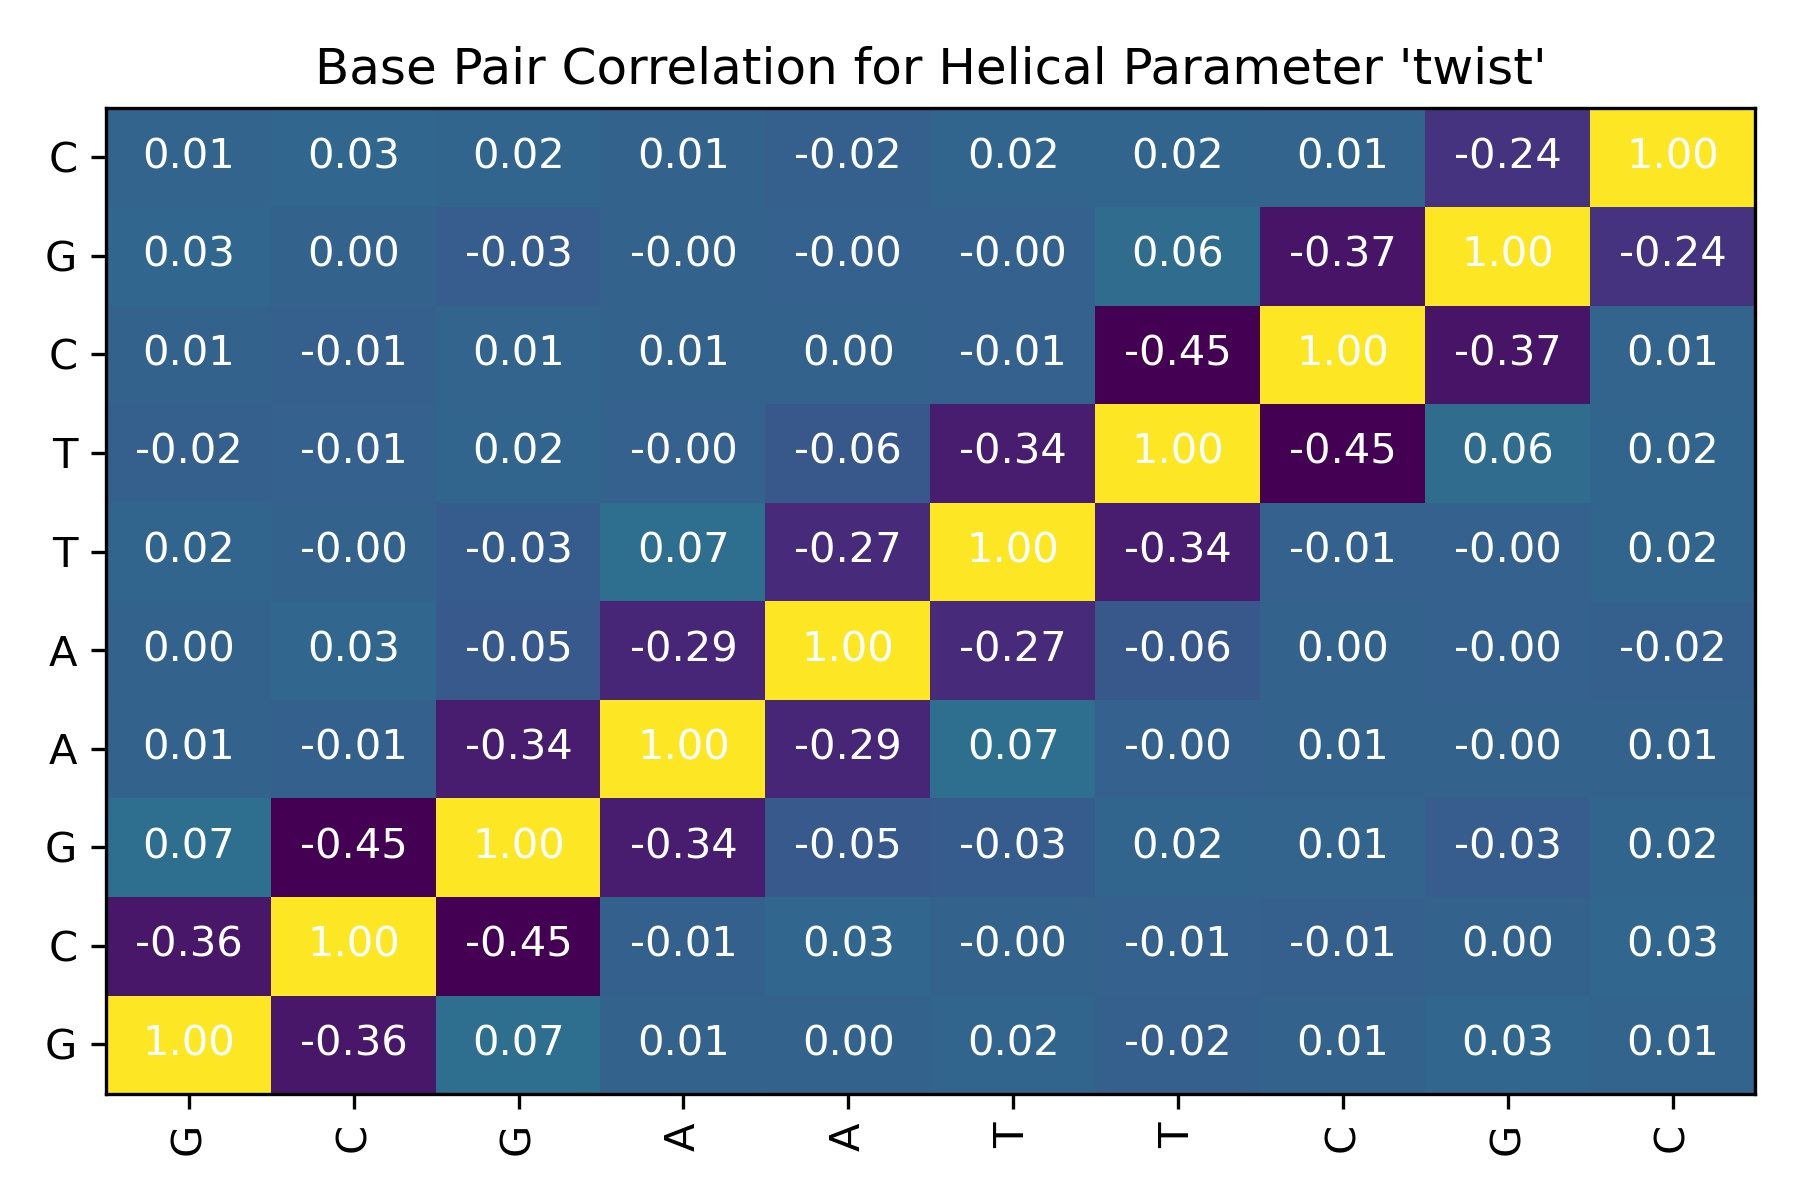

In [60]:
Image(filename=output_intrabp_correlation_jpg_path,width = 600)

<a id="intersequencecorrelation"></a>
### Sequence Correlations: Inter-base pair steps

In [ ]:
from biobb_dna.interbp_correlations.interseqcorr import intersequencecorrelation

input_file_path = "canal_out/canal_output" + "_" + helpar + ".ser"
output_interbp_correlation_csv_path = helpar+'.interbp_correlation.csv'
output_interbp_correlation_jpg_path = helpar+'.interbp_correlation.jpg'

prop={
    'sequence' : seq,
#    'helpar_name' : 'Rise'
}

intersequencecorrelation(
    input_ser_path=input_file_path,
    output_csv_path=output_interbp_correlation_csv_path,
    output_jpg_path=output_interbp_correlation_jpg_path,
    properties=prop)

In [62]:
df = pd.read_csv(output_interbp_correlation_csv_path)
df

Unnamed: 0        GC        CG        GA        AA        AT        TT  \
0          GC  1.000000 -0.358404  0.068163  0.009405  0.001087  0.019698   
1          CG -0.358404  1.000000 -0.448247 -0.007771  0.026130 -0.000455   
2          GA  0.068163 -0.448247  1.000000 -0.335686 -0.048327 -0.029954   
3          AA  0.009405 -0.007771 -0.335686  1.000000 -0.293111  0.070316   
4          AT  0.001087  0.026130 -0.048327 -0.293111  1.000000 -0.273114   
5          TT  0.019698 -0.000455 -0.029954  0.070316 -0.273114  1.000000   
6          TC -0.015957 -0.005333  0.018416 -0.003760 -0.056474 -0.335193   
7      CG_dup  0.007849 -0.013427  0.013668  0.006406  0.001153 -0.006889   
8      GC_dup  0.031577  0.001874 -0.026111 -0.000036 -0.002821 -0.001462   
9  CG_dup_dup  0.010621  0.025165  0.016239  0.007260 -0.016981  0.017912   

         TC    CG_dup    GC_dup  CG_dup_dup  
0 -0.015957  0.007849  0.031577    0.010621  
1 -0.005333 -0.013427  0.001874    0.025165  
2  0.018416  0.013668 -0.026111    0.016239  
3 -0.003760  0.006406 -0.000036    0.007260  
4 -0.056474  0.001153 -0.002821   -0.016981  
5 -0.335193 -0.006889 -0.001462    0.017912  
6  1.000000 -0.447663  0.059009    0.019932  
7 -0.447663  1.000000 -0.372677    0.014933  
8  0.059009 -0.372677  1.000000   -0.236134  
9  0.019932  0.014933 -0.236134    1.000000

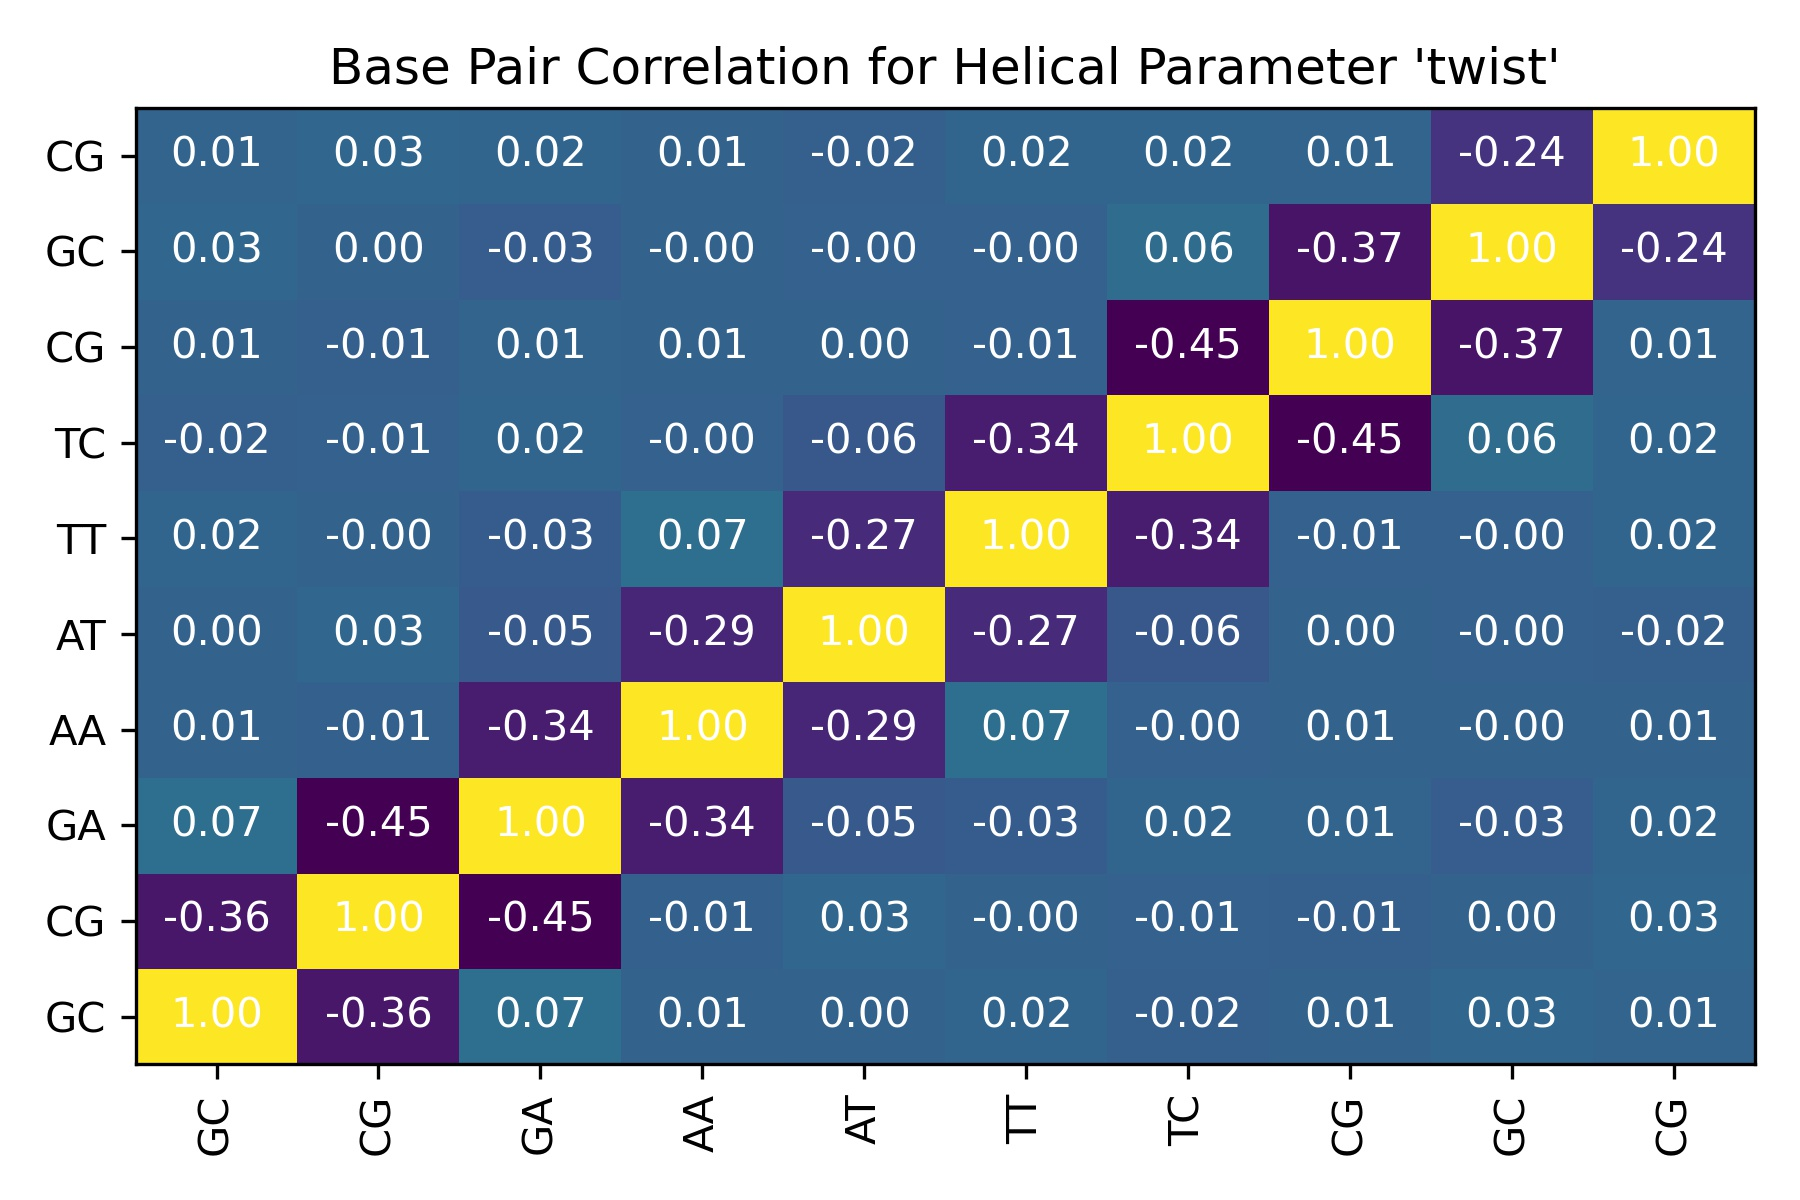

In [63]:
Image(filename=output_interbp_correlation_jpg_path,width = 600)

<a id="intrahelparcorrelation"></a>
### Helical Parameter Correlations: Intra-base pair 

In [ ]:
from biobb_dna.intrabp_correlations.intrahpcorr import intrahelparcorrelation

timeseries_shear = timeseries_dir+"/series_shear_"+timesel.value[:-1]+".csv"
timeseries_stretch = timeseries_dir+"/series_stretch_"+timesel.value[:-1]+".csv"
timeseries_stagger = timeseries_dir+"/series_stagger_"+timesel.value[:-1]+".csv"
timeseries_buckle = timeseries_dir+"/series_buckle_"+timesel.value[:-1]+".csv"
timeseries_propel = timeseries_dir+"/series_propel_"+timesel.value[:-1]+".csv"
timeseries_opening = timeseries_dir+"/series_opening_"+timesel.value[:-1]+".csv"

output_helpar_bp_correlation_csv_path = "helpar_bp_correlation.csv"
output_helpar_bp_correlation_jpg_path = "helpar_bp_correlation.jpg"

intrahelparcorrelation(
    input_filename_shear=timeseries_shear,
    input_filename_stretch=timeseries_stretch,
    input_filename_stagger=timeseries_stagger,
    input_filename_buckle=timeseries_buckle,
    input_filename_propel=timeseries_propel,
    input_filename_opening=timeseries_opening,
    output_csv_path=output_helpar_bp_correlation_csv_path,
    output_jpg_path=output_helpar_bp_correlation_jpg_path)


In [65]:
df = pd.read_csv(output_helpar_bp_correlation_csv_path)
df

Unnamed: 0     shear   stretch   stagger    buckle    propel   opening
0      shear  1.000000 -0.122310  0.062783 -0.024045  0.012255  0.066297
1    stretch -0.122310  1.000000 -0.024948 -0.141840 -0.034225  0.396172
2    stagger  0.062783 -0.024948  1.000000 -0.172773 -0.253086  0.138571
3     buckle -0.024045 -0.141840 -0.172773  1.000000  0.029668  0.000972
4     propel  0.012255 -0.034225 -0.253086  0.029668  1.000000 -0.138484
5    opening  0.066297  0.396172  0.138571  0.000972 -0.138484  1.000000

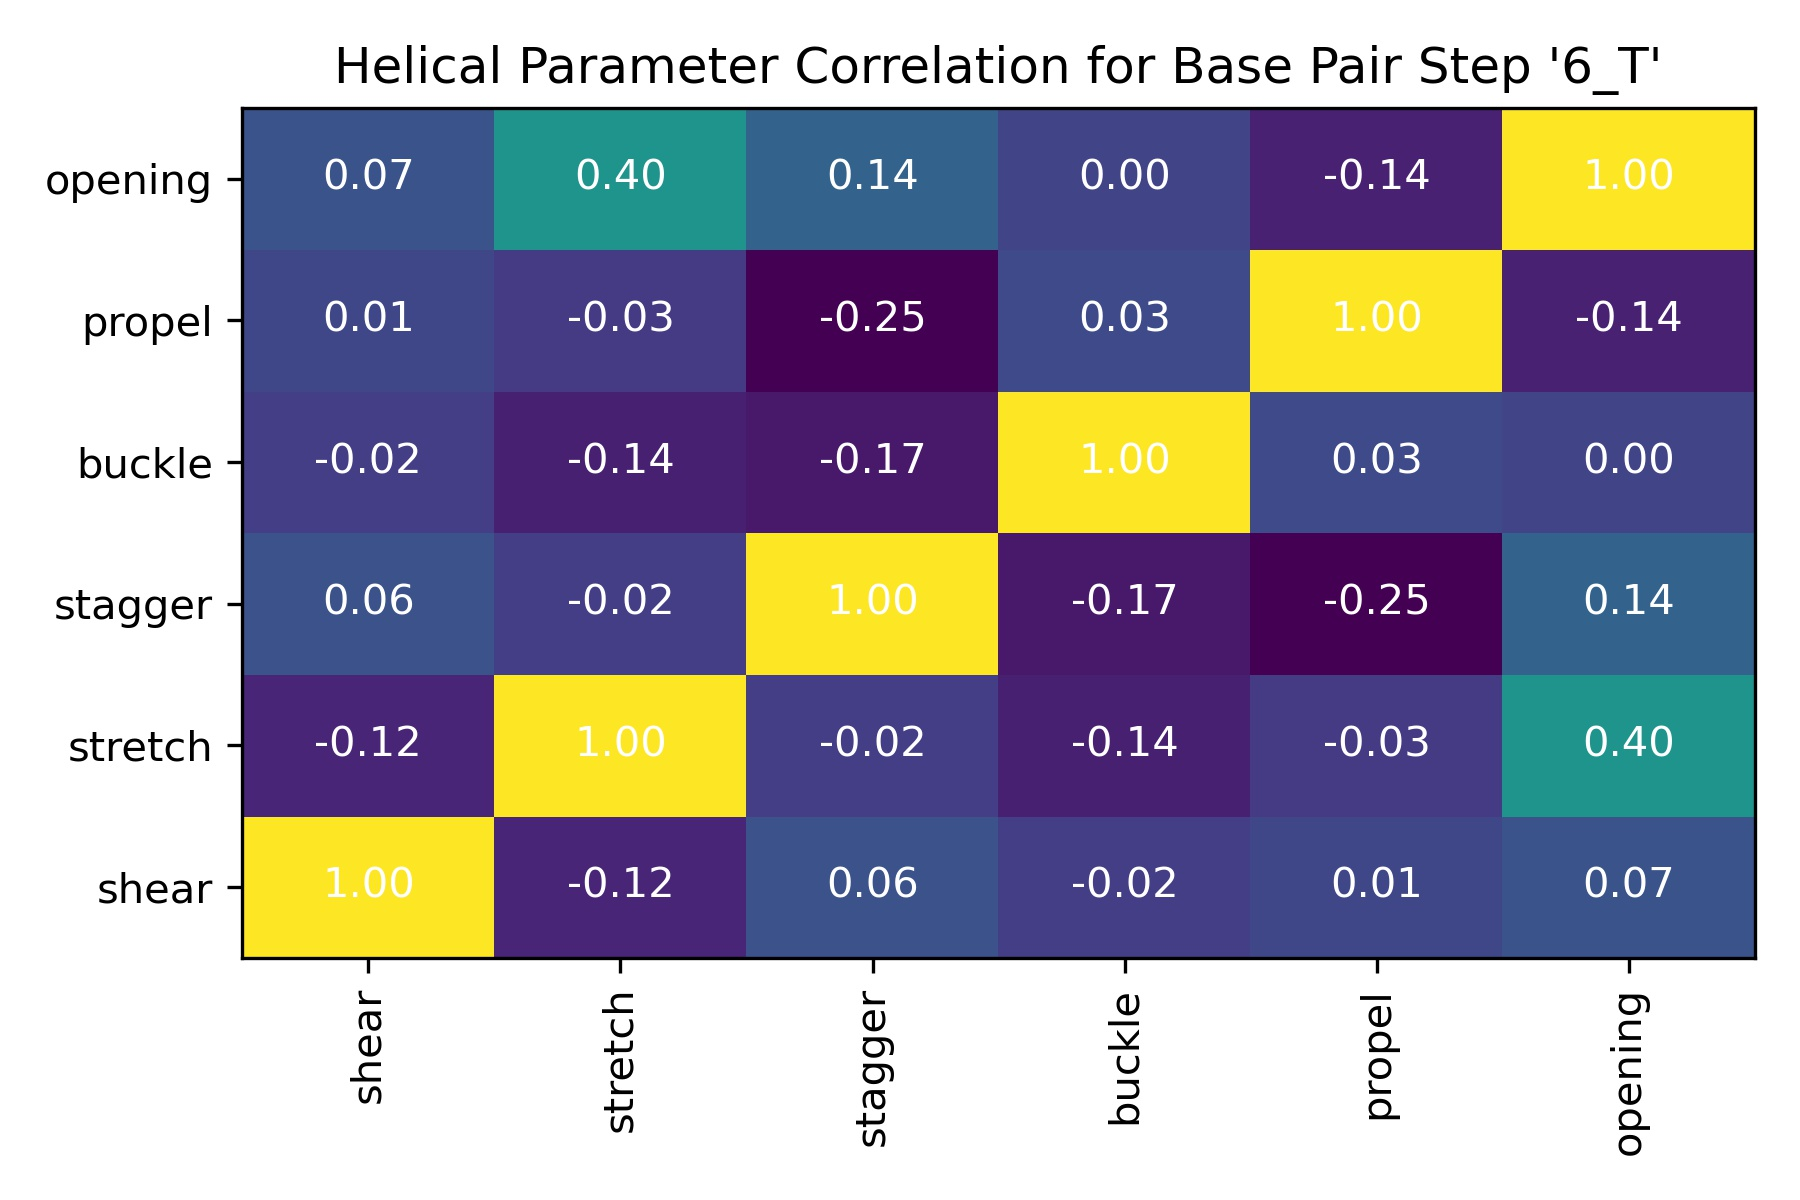

In [66]:
Image(filename=output_helpar_bp_correlation_jpg_path,width = 600)

<a id="interhelparcorrelation"></a>
### Helical Parameter Correlations: Inter-base pair steps

In [ ]:
from biobb_dna.interbp_correlations.interhpcorr import interhelparcorrelation

timeseries_shift = timeseries_dir+"/series_shift_"+timesel.value+".csv"
timeseries_slide = timeseries_dir+"/series_slide_"+timesel.value+".csv"
timeseries_rise = timeseries_dir+"/series_rise_"+timesel.value+".csv"
timeseries_tilt = timeseries_dir+"/series_tilt_"+timesel.value+".csv"
timeseries_roll = timeseries_dir+"/series_roll_"+timesel.value+".csv"
timeseries_twist = timeseries_dir+"/series_twist_"+timesel.value+".csv"

output_helpar_bps_correlation_csv_path = "helpar_bps_correlation.csv"
output_helpar_bps_correlation_jpg_path = "helpar_bps_correlation.jpg"

interhelparcorrelation(
    input_filename_shift=timeseries_shift,
    input_filename_slide=timeseries_slide,
    input_filename_rise=timeseries_rise,
    input_filename_tilt=timeseries_tilt,
    input_filename_roll=timeseries_roll,
    input_filename_twist=timeseries_twist,
    output_csv_path=output_helpar_bps_correlation_csv_path,
    output_jpg_path=output_helpar_bps_correlation_jpg_path)


In [68]:
df = pd.read_csv(output_helpar_bps_correlation_csv_path)
df

Unnamed: 0     shift     slide      rise      tilt      roll     twist
0      shift  1.000000  0.439831  0.006659  0.166307  0.113906  0.318624
1      slide  0.439831  1.000000 -0.207299  0.151236  0.141627  0.541202
2       rise  0.006659 -0.207299  1.000000 -0.173336 -0.224263  0.147534
3       tilt  0.166307  0.151236 -0.173336  1.000000 -0.032611  0.084610
4       roll  0.113906  0.141627 -0.224263 -0.032611  1.000000 -0.109835
5      twist  0.318624  0.541202  0.147534  0.084610 -0.109835  1.000000

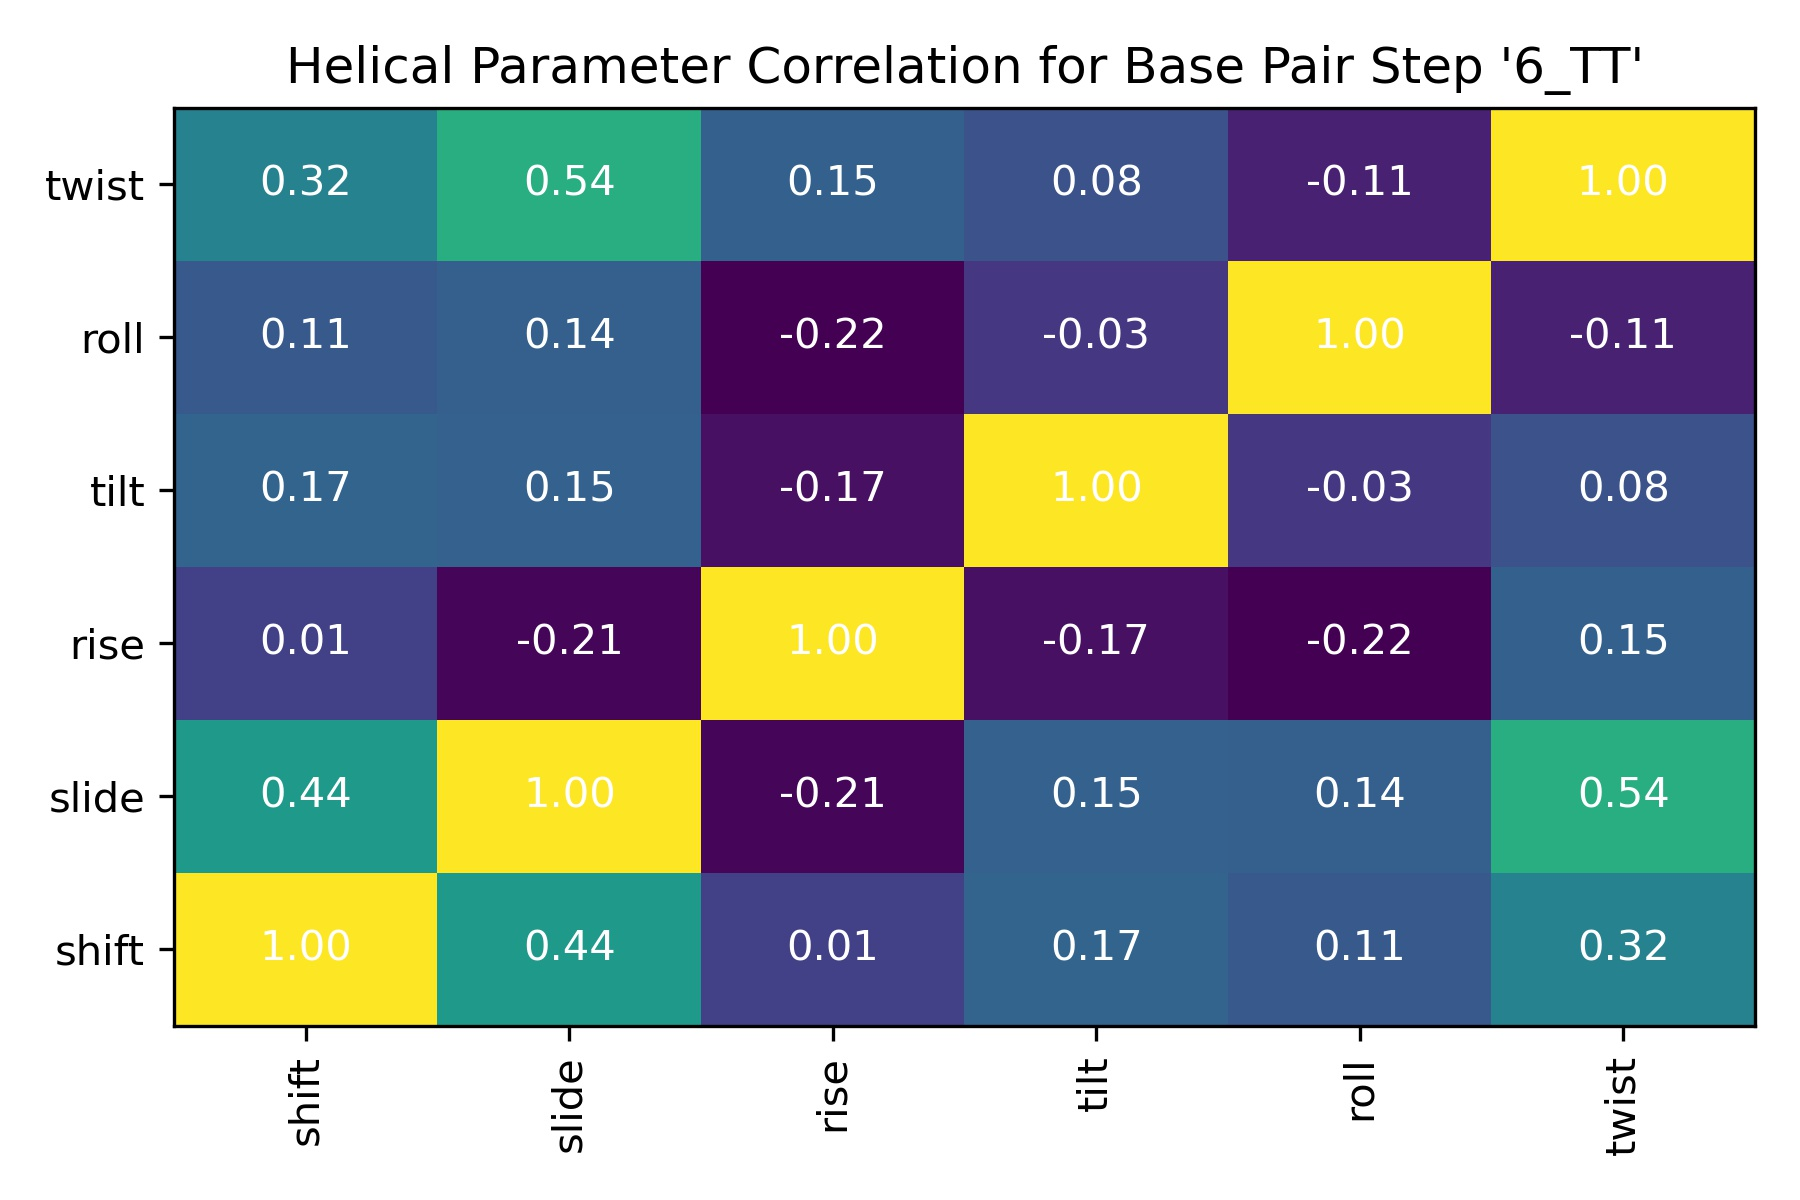

In [69]:
Image(filename=output_helpar_bps_correlation_jpg_path,width = 600)

<a id="intrabasepaircorrelation"></a>
### Neighboring steps Correlations: Intra-base pair 

In [ ]:
from biobb_dna.intrabp_correlations.intrabpcorr import intrabasepaircorrelation

canal_shear = canal_dir+"/canal_output_shear.ser"
canal_stretch = canal_dir+"/canal_output_stretch.ser"
canal_stagger = canal_dir+"/canal_output_stagger.ser"
canal_buckle = canal_dir+"/canal_output_buckle.ser"
canal_propel = canal_dir+"/canal_output_propel.ser"
canal_opening = canal_dir+"/canal_output_opening.ser"

output_bp_correlation_csv_path = "bp_correlation.csv"
output_bp_correlation_jpg_path = "bp_correlation.jpg"

prop = {
    'sequence' : seq
}

intrabasepaircorrelation(
    input_filename_shear=canal_shear,
    input_filename_stretch=canal_stretch,
    input_filename_stagger=canal_stagger,
    input_filename_buckle=canal_buckle,
    input_filename_propel=canal_propel,
    input_filename_opening=canal_opening,
    output_csv_path=output_bp_correlation_csv_path,
    output_jpg_path=output_bp_correlation_jpg_path,
    properties=prop)

In [71]:
df = pd.read_csv(output_bp_correlation_csv_path)
df

Unnamed: 0  shear/shear  shear/stretch  shear/stagger  shear/buckle  \
0         GC    -0.005642       0.018630      -0.025087     -0.010539   
1         CG     0.020041       0.051434       0.001951     -0.059043   
2         GA    -0.037801       0.027801      -0.015043     -0.105601   
3         AA     0.023788      -0.000117      -0.004595     -0.027747   
4         AT     0.032575       0.003270      -0.028156     -0.070385   
5         TT    -0.010285      -0.009504       0.035414      0.004137   
6         TC     0.002390       0.003433      -0.024093      0.014480   
7         CG    -0.027842       0.002501       0.014905      0.010619   
8         GC    -0.030918       0.025377       0.047997     -0.149693   
9         CG    -0.001727       0.039837       0.013472     -0.031293   

   shear/propel  shear/opening  stretch/shear  stretch/stretch  \
0      0.024243       0.019345      -0.011061         0.021519   
1      0.027216       0.045336      -0.051213        -0.033895   
2      0.073992       0.025790      -0.010322         0.043308   
3     -0.031901      -0.041804       0.023817        -0.006556   
4     -0.066959       0.021602       0.014530         0.014772   
5      0.003110       0.052842      -0.020711         0.005863   
6     -0.012981       0.059420       0.030606         0.011428   
7      0.018963       0.030263      -0.020690         0.016758   
8      0.032799       0.004369      -0.029652         0.018781   
9     -0.014562       0.043469      -0.018693        -0.008573   

   stretch/stagger  ...  propel/stagger  propel/buckle  propel/propel  \
0        -0.020824  ...       -0.024222       0.005585       0.006706   
1         0.009731  ...        0.047045      -0.335039      -0.122872   
2         0.011708  ...        0.073619      -0.176741      -0.051962   
3        -0.005822  ...       -0.061579      -0.147203      -0.004269   
4        -0.047132  ...       -0.113304      -0.173226       0.107649   
5        -0.007229  ...       -0.091332      -0.132041       0.183310   
6         0.005235  ...       -0.019650      -0.152708       0.080905   
7         0.033150  ...        0.063238      -0.222382       0.012536   
8         0.037963  ...        0.063868      -0.188492      -0.044925   
9         0.026310  ...        0.044891      -0.303367      -0.113362   

   propel/opening  opening/shear  opening/stretch  opening/stagger  \
0       -0.021960      -0.010185         0.006839        -0.011742   
1       -0.067494      -0.047289        -0.037659         0.023410   
2        0.003138       0.029520         0.005160         0.051622   
3       -0.050649      -0.039697         0.035455        -0.018540   
4        0.019869      -0.036929        -0.020634        -0.030510   
5        0.023056      -0.051025         0.023035        -0.017409   
6        0.021846      -0.012044         0.067861        -0.083172   
7       -0.021479      -0.042303         0.020077         0.014984   
8       -0.027264      -0.025809         0.027768         0.030092   
9       -0.080200      -0.018591        -0.029267         0.032287   

   opening/buckle  opening/propel  opening/opening  
0        0.001443        0.005266         0.019129  
1       -0.105277       -0.082899         0.005289  
2        0.007026       -0.017732         0.021906  
3       -0.093678       -0.048917         0.042879  
4        0.021788        0.036952         0.119437  
5        0.003068        0.010977         0.191239  
6        0.048029        0.028434         0.151051  
7       -0.018558       -0.076957         0.006822  
8       -0.062296        0.025229         0.019334  
9       -0.095808       -0.074735        -0.005167  

[10 rows x 37 columns]

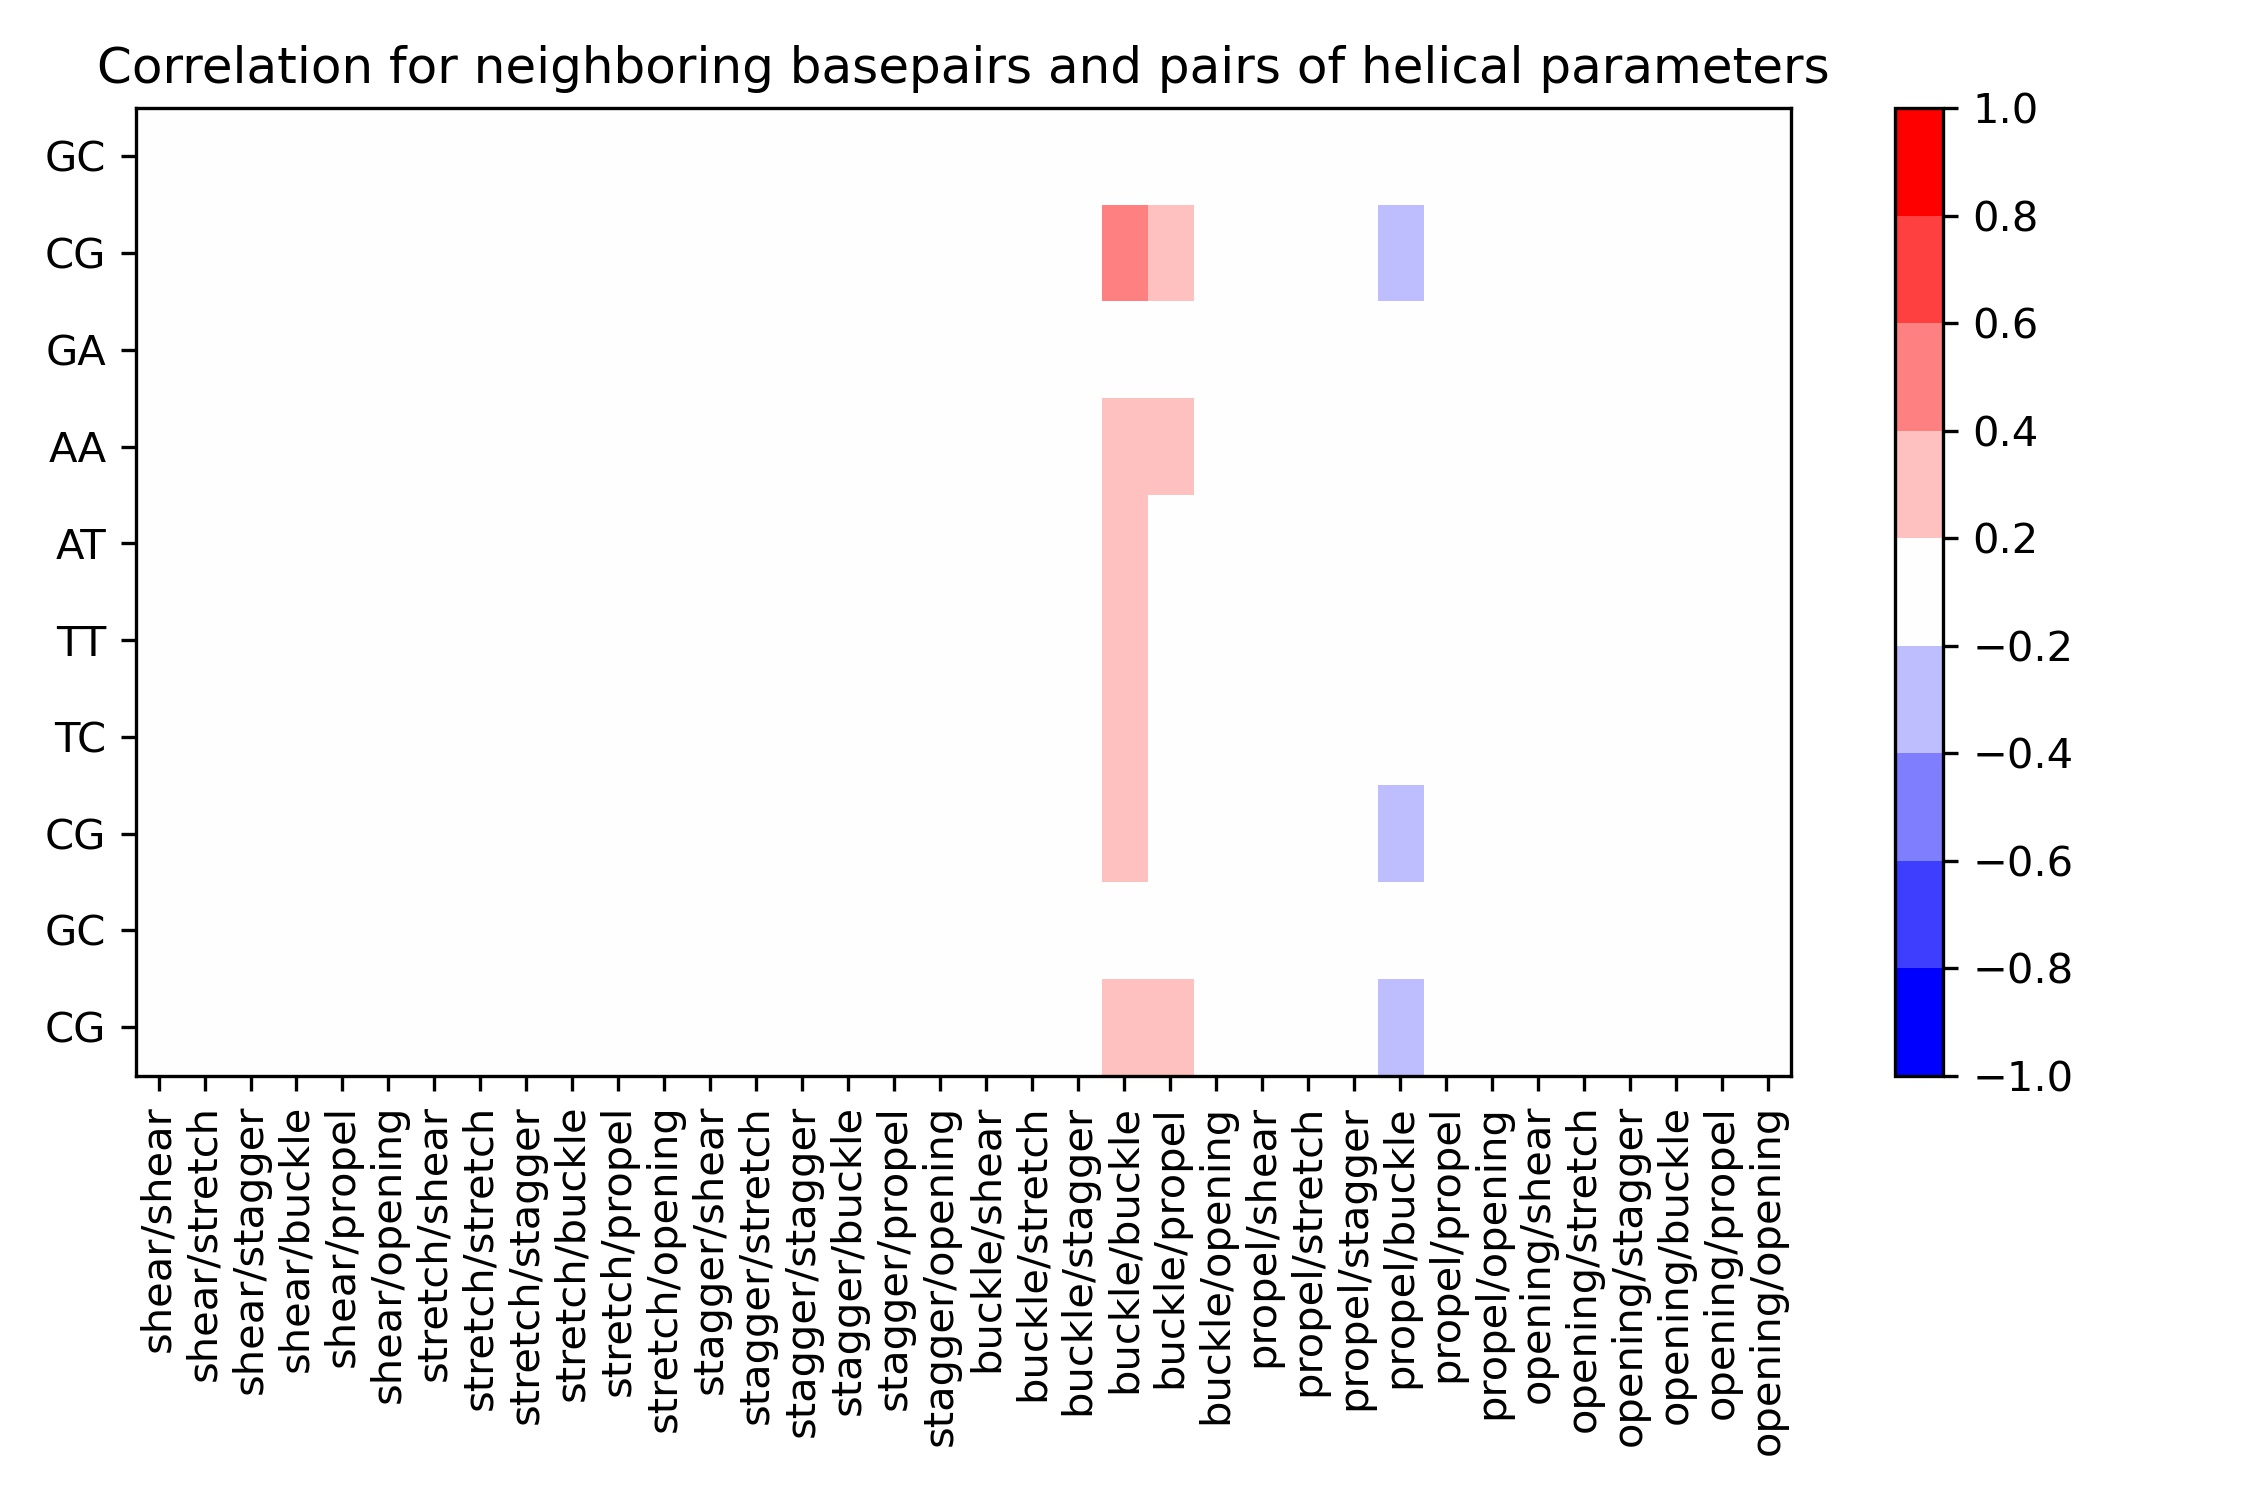

In [72]:
Image(filename=output_bp_correlation_jpg_path,width = 800)

<a id="interbasepaircorrelation"></a>
### Neighboring steps Correlations: Inter-base pair steps

In [ ]:
from biobb_dna.interbp_correlations.interbpcorr import interbasepaircorrelation

canal_shift = canal_dir+"/canal_output_shift.ser"
canal_slide = canal_dir+"/canal_output_slide.ser"
canal_rise = canal_dir+"/canal_output_rise.ser"
canal_tilt = canal_dir+"/canal_output_tilt.ser"
canal_roll = canal_dir+"/canal_output_roll.ser"
canal_twist = canal_dir+"/canal_output_twist.ser"

output_bps_correlation_csv_path = "bps_correlation.csv"
output_bps_correlation_jpg_path = "bps_correlation.jpg"

prop = {
    'sequence' : seq
}

interbasepaircorrelation(
    input_filename_shift=canal_shift,
    input_filename_slide=canal_slide,
    input_filename_rise=canal_rise,
    input_filename_tilt=canal_tilt,
    input_filename_roll=canal_roll,
    input_filename_twist=canal_twist,
    output_csv_path=output_bps_correlation_csv_path,
    output_jpg_path=output_bps_correlation_jpg_path,
    properties=prop)

In [74]:
df = pd.read_csv(output_bps_correlation_csv_path)
df

Unnamed: 0  shift/shift  shift/slide  shift/rise  shift/tilt  shift/roll  \
0        GCG    -0.034515    -0.013978    0.028504   -0.016774    0.007526   
1        CGA    -0.620729    -0.213534    0.153552   -0.379811   -0.069482   
2        GAA    -0.556258    -0.055634    0.106571   -0.307558   -0.124963   
3        AAT    -0.422776     0.121578    0.172917   -0.120018   -0.234489   
4        ATT    -0.135159     0.048764    0.052558    0.152407   -0.137398   
5        TTC    -0.115228     0.074008    0.011805    0.204128   -0.216200   
6        TCG    -0.428290    -0.230813    0.116441    0.057122   -0.208447   
7        CGC    -0.577276    -0.389311    0.286179   -0.324285   -0.179625   
8        GCG    -0.626682     0.229957    0.290226   -0.338901   -0.240202   

   shift/twist  slide/shift  slide/slide  slide/rise  ...  roll/rise  \
0    -0.019706    -0.005945     0.003258    0.016998  ...  -0.024289   
1     0.090324    -0.185796     0.035204   -0.072609  ...   0.185182   
2     0.111320     0.336513     0.207062    0.010327  ...   0.243220   
3     0.333776     0.200294     0.055308   -0.062561  ...   0.182963   
4     0.093877    -0.058611     0.177430    0.140074  ...   0.189502   
5    -0.032101    -0.028032     0.184504    0.114301  ...   0.113645   
6    -0.118440    -0.121029     0.055468    0.090725  ...   0.093449   
7     0.071846     0.054698     0.233093   -0.148480  ...   0.140274   
8     0.328321     0.213949     0.040634    0.007077  ...   0.287660   

   roll/tilt  roll/roll  roll/twist  twist/shift  twist/slide  twist/rise  \
0   0.034074  -0.014922    0.002918     0.024087     0.011902   -0.018600   
1   0.239957  -0.327237    0.146238    -0.301986    -0.066687   -0.230273   
2   0.222142  -0.356105    0.262547    -0.112359    -0.169531   -0.267369   
3   0.269344  -0.261031    0.037170    -0.055827    -0.035366   -0.125160   
4   0.241552  -0.262516    0.016017    -0.027548    -0.024130   -0.059852   
5   0.247625  -0.299766   -0.015864    -0.148998     0.111239    0.075143   
6   0.287541  -0.273905    0.101453    -0.316904    -0.253028   -0.076103   
7   0.210203  -0.362062    0.244422    -0.150061    -0.097582   -0.265051   
8   0.196857  -0.327687    0.263437    -0.127565    -0.149207   -0.200700   

   twist/tilt  twist/roll  twist/twist  
0   -0.000658    0.004749     0.031633  
1   -0.149935    0.234940    -0.358276  
2   -0.017553    0.222109    -0.448559  
3   -0.008524    0.080896    -0.336058  
4   -0.003261    0.031997    -0.293106  
5    0.053240   -0.015885    -0.273020  
6   -0.114819    0.066582    -0.335519  
7   -0.021533    0.240612    -0.447802  
8   -0.092674    0.171328    -0.372676  

[9 rows x 37 columns]

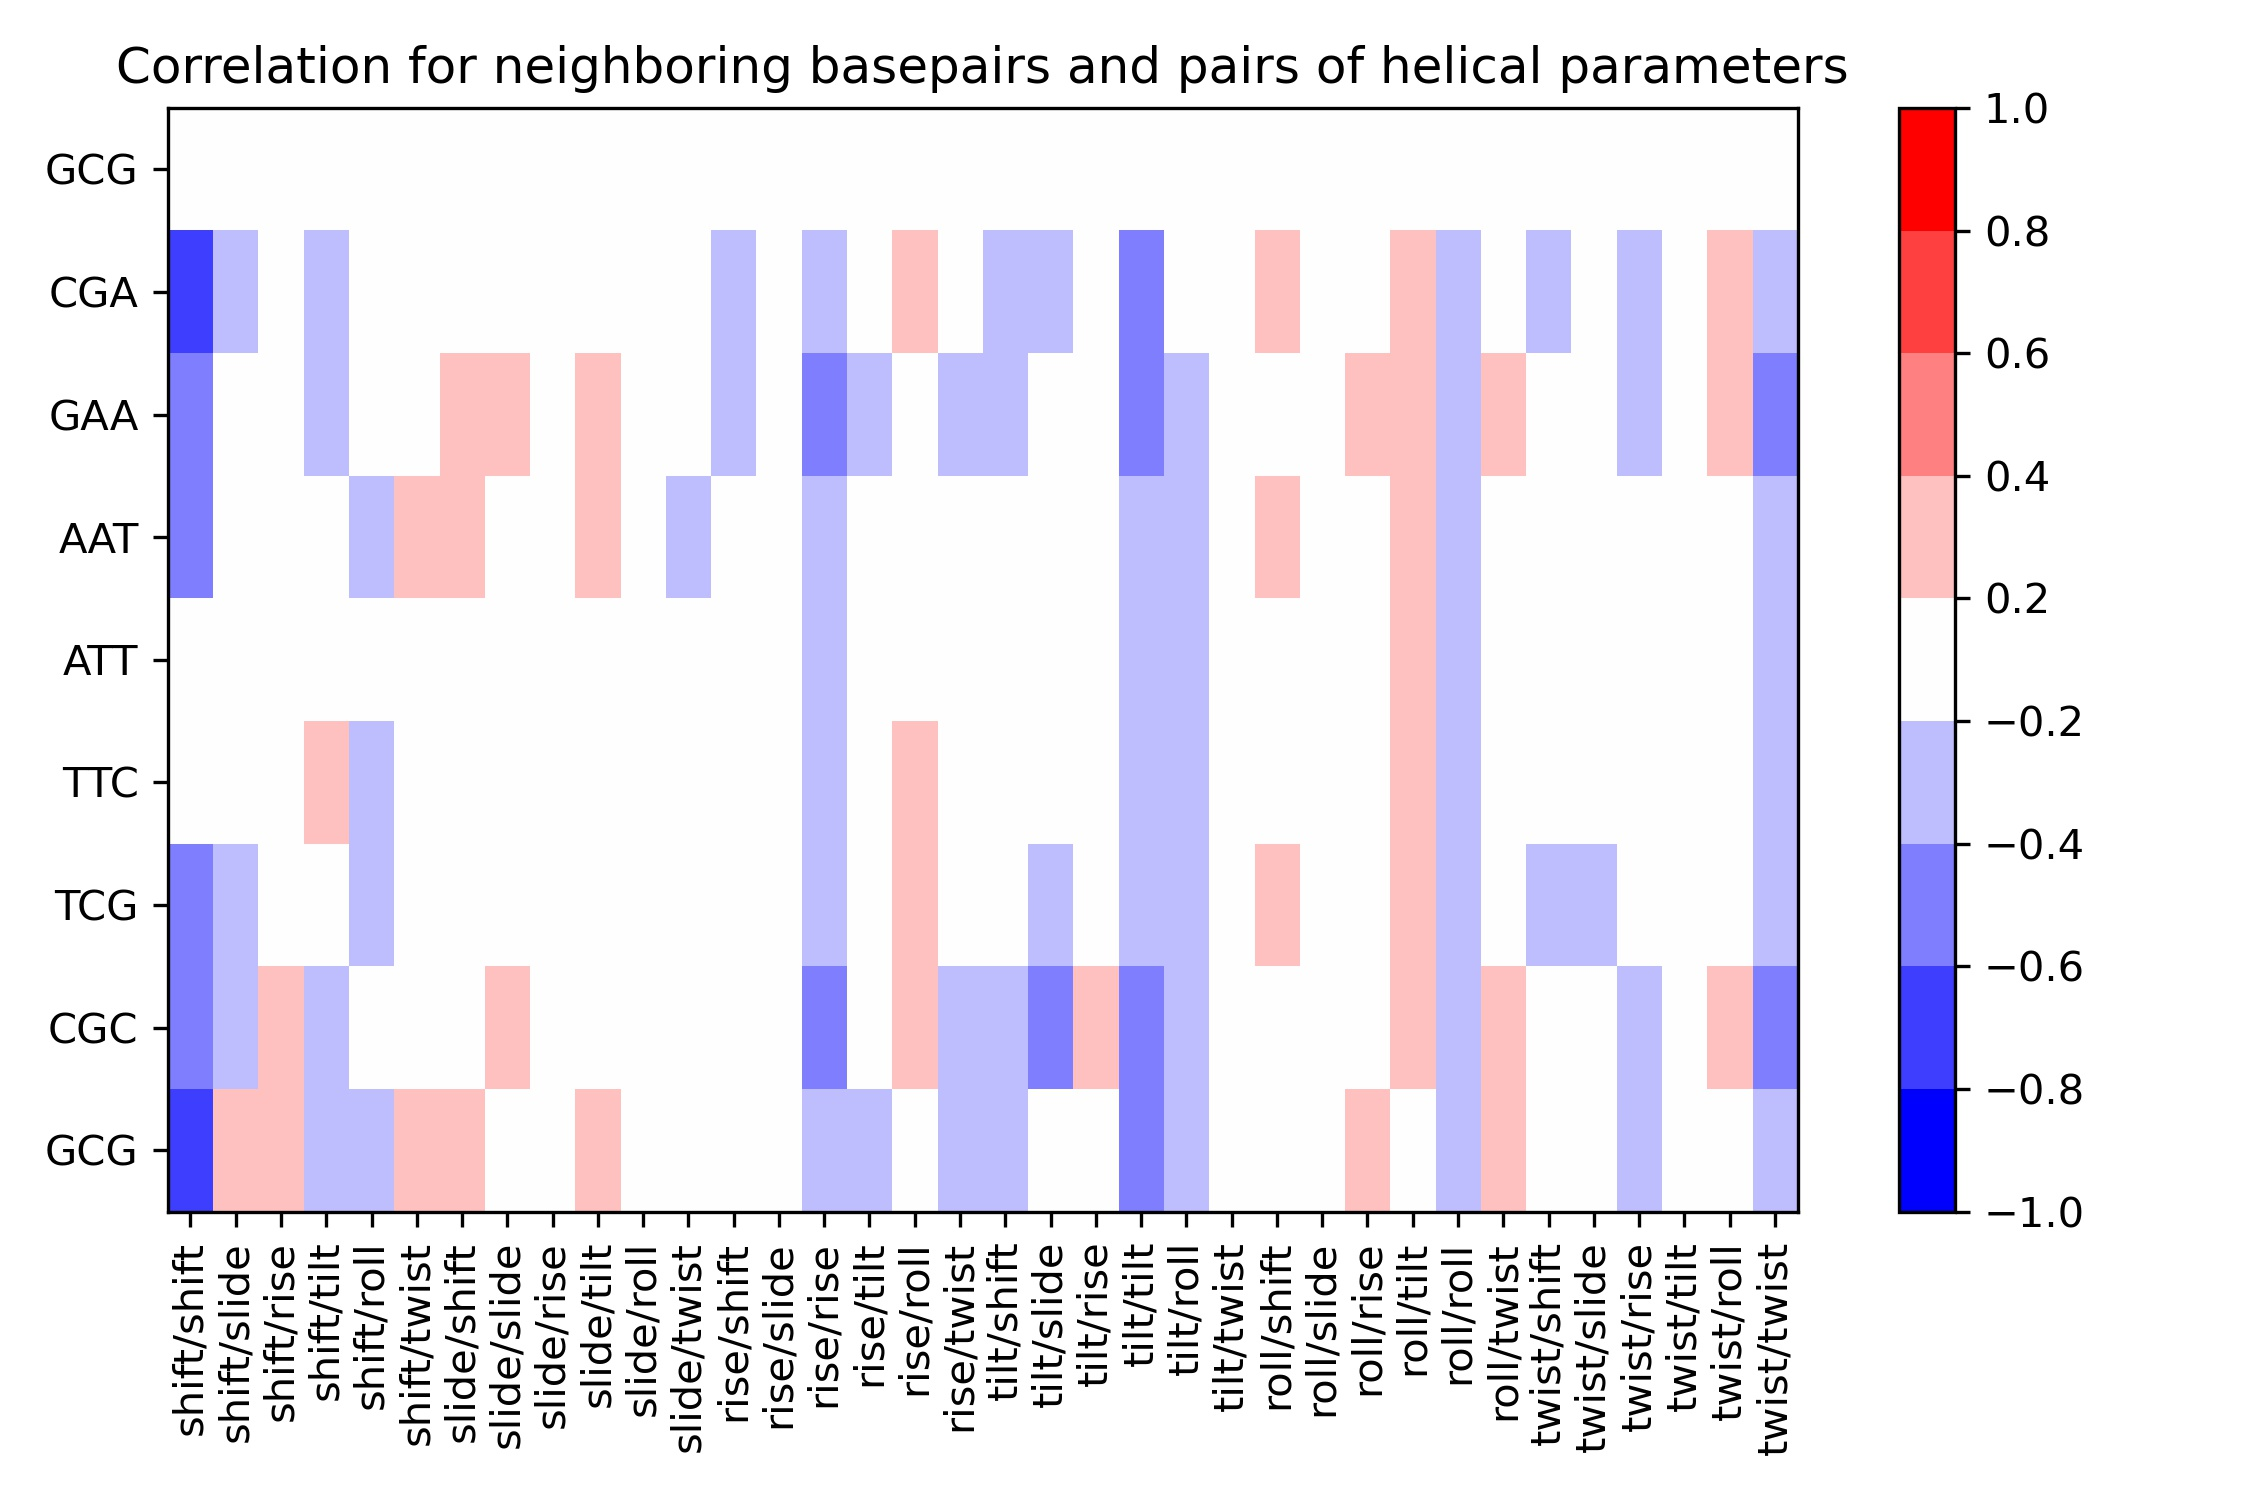

In [75]:
Image(filename=output_bps_correlation_jpg_path,width = 800)

***
<a id="questions"></a>

## Questions & Comments

Questions, issues, suggestions and comments are really welcome!

* GitHub issues:
    * [https://github.com/bioexcel/biobb](https://github.com/bioexcel/biobb)

* BioExcel forum:
    * [https://ask.bioexcel.eu/c/BioExcel-Building-Blocks-library](https://ask.bioexcel.eu/c/BioExcel-Building-Blocks-library)
